In [1]:
# 这个代码每个epoch都跑一遍训练集和验证集

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# 参数
learning_rate = 0.001
momentum = 0.9
epochs = 40
batch_size = 4
display_step = 1
shuffle = True
num_classes = 4

In [2]:
# 加载densenet121预训练模型
model = models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 4)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [3]:
# 数据准备
# crop:裁剪 resize:缩放 flip:翻转
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# your image data file
data_dir = './images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'validation']}
# torchvision.datasets.ImageFolder返回的是list，这里用torch.utils.data.DataLoader类将list类型的输入数据封装成Tensor数据格式
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             num_workers=10) for x in ['train', 'validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

In [4]:
# 是否使用GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

print("use_gpu: " + str(use_gpu))
    
# 定义损失函数，这里采用交叉熵函数
loss_fn = nn.CrossEntropyLoss()

# 定义优化函数，这里采用随机梯度下降法
optimizer = optim.SGD(model.parameters(), learning_rate, momentum)

# 定义学习率的变化策略，这里采用torch.optim.lr_scheduler模块的StepLR类，表示每隔step_size个epoch就将学习率降为原来的gamma倍
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

use_gpu: True


In [5]:
# 开始训练
since = time.time()
best_model_wts = model.state_dict()
best_acc = 0.0
loss_train = []  # 训练集loss
acc_train = []  # 训练集正确率
loss_val = []  # 验证集loss
acc_val = []  # 验证集正确率
best_matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

for epoch in range(epochs):
    if epoch % display_step == 0:
        print('Epoch [{}/{}]:'.format(epoch + 1, epochs))

    # 每一轮都跑一遍训练集和验证集
    for phase in ['train', 'validation']:
        if phase == 'train':
            i = 1
            j = 1
            # exp_lr_scheduler.step()
            model.train()  # 把module设成training模式，对Dropout和BatchNorm有影响
        else:
            i = 1
            j = 2
            model.eval()  # 把module设置为评估模式

        running_loss = 0.0
        running_corrects = 0
        matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            # if use_gpu:
            #     inputs = inputs.cuda()
            #     labels = labels.cuda()
            # else:
            #     inputs, labels = Variable(inputs), Variable(labels)

            # PyTorch更新至0.4.0后，将Variable和Tensor合并
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # 先将网络中的所有梯度置0
            optimizer.zero_grad()

            # 网络的前向传播
            outputs = model(inputs)

            # 计算损失
            loss = loss_fn(outputs, labels)

            # 得到模型预测该样本属于哪个类别的信息
            # '_'就是一个变量，换成a也是可以的，没有特别的意思，不过一般用_表示的变量好像都是没什么用的一个临时变量，大概是
            # 一个编程习惯吧。所以这边'_,'没有特殊的含义，'_'就是一个变量，只是为了让preds取到max函数返回值的第二项，
            # 即找到的最大值的索引位置（对应到这里就是类别标签）
            # （max函数解释见https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max）
            _, preds = torch.max(outputs.data, 1)

            # 训练时，应用回传和优化
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # 记录当前batch_size的loss以及数据对应的分类准确数量
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            if phase == 'validation':
                for k in range(0, num_classes):
                    matrix[labels.data.cpu().numpy()[k]][preds.cpu().numpy()[k]] += 1

            print('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch + 1, i, loss.item()/4, torch.sum(preds == labels.data).item()/4.0*100))
            i = i + 1

        # 计算并打印这一轮训练的loss和分类准确率
        if j == 1:
            epoch_loss_train = running_loss / dataset_sizes['train']
            epoch_acc_train = running_corrects.item() / dataset_sizes['train']
            loss_train.append(epoch_loss_train)
            acc_train.append(epoch_acc_train)            
        else:
            epoch_loss_val = running_loss / dataset_sizes['validation']
            epoch_acc_val = running_corrects.item() / dataset_sizes['validation']
            loss_val.append(epoch_loss_val)
            acc_val.append(epoch_acc_val)

        if epoch % display_step == 0 and j == 2:
            print('\ttrain Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_train, epoch_acc_train*100))
            print('\tvalidation Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_val, epoch_acc_val*100))

        # deep copy the model
        if phase == 'validation' and epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = model.state_dict()
            print("网络参数更新")
            # 保存最优参数
            torch.save(best_model_wts, './parameter/params_densenet121.pth')
            best_matrix = copy.deepcopy(matrix)
#             print("Model's state_dict:")
#             for param_tensor in best_model_wts:
#                 print(param_tensor, "\t", best_model_wts[param_tensor].size())
    time_elapsed = time.time() - since
    print('Time passed {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    print('-' * 20)

# 计算训练所耗时间
time_elapsed = time.time() - since
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))

Epoch [1/40]:
	train 1-1: Loss: 0.3408 Acc: 0.0000%
	train 1-2: Loss: 0.3412 Acc: 0.0000%
	train 1-3: Loss: 0.3297 Acc: 0.0000%
	train 1-4: Loss: 0.3548 Acc: 25.0000%
	train 1-5: Loss: 0.3106 Acc: 25.0000%
	train 1-6: Loss: 0.3681 Acc: 25.0000%
	train 1-7: Loss: 0.3053 Acc: 50.0000%
	train 1-8: Loss: 0.4291 Acc: 0.0000%
	train 1-9: Loss: 0.2934 Acc: 75.0000%
	train 1-10: Loss: 0.3481 Acc: 25.0000%
	train 1-11: Loss: 0.2626 Acc: 50.0000%
	train 1-12: Loss: 0.4329 Acc: 25.0000%
	train 1-13: Loss: 0.3589 Acc: 25.0000%
	train 1-14: Loss: 0.3841 Acc: 50.0000%
	train 1-15: Loss: 0.3908 Acc: 25.0000%
	train 1-16: Loss: 0.2650 Acc: 75.0000%
	train 1-17: Loss: 0.3220 Acc: 50.0000%
	train 1-18: Loss: 0.3463 Acc: 25.0000%
	train 1-19: Loss: 0.3787 Acc: 25.0000%
	train 1-20: Loss: 0.3593 Acc: 25.0000%
	train 1-21: Loss: 0.3874 Acc: 0.0000%
	train 1-22: Loss: 0.3245 Acc: 25.0000%
	train 1-23: Loss: 0.3442 Acc: 50.0000%
	train 1-24: Loss: 0.3017 Acc: 25.0000%
	train 1-25: Loss: 0.3035 Acc: 50.0000%


	train 1-204: Loss: 0.2539 Acc: 50.0000%
	train 1-205: Loss: 0.4606 Acc: 0.0000%
	train 1-206: Loss: 0.2918 Acc: 50.0000%
	train 1-207: Loss: 0.1399 Acc: 100.0000%
	train 1-208: Loss: 0.0592 Acc: 100.0000%
	train 1-209: Loss: 0.1239 Acc: 100.0000%
	train 1-210: Loss: 0.2970 Acc: 75.0000%
	train 1-211: Loss: 0.1102 Acc: 100.0000%
	train 1-212: Loss: 0.2353 Acc: 50.0000%
	train 1-213: Loss: 0.2355 Acc: 75.0000%
	train 1-214: Loss: 0.1951 Acc: 50.0000%
	train 1-215: Loss: 0.3053 Acc: 50.0000%
	train 1-216: Loss: 0.1189 Acc: 75.0000%
	train 1-217: Loss: 0.1800 Acc: 50.0000%
	train 1-218: Loss: 0.1083 Acc: 75.0000%
	train 1-219: Loss: 0.2990 Acc: 25.0000%
	train 1-220: Loss: 0.1341 Acc: 100.0000%
	train 1-221: Loss: 0.0885 Acc: 75.0000%
	train 1-222: Loss: 0.1730 Acc: 75.0000%
	train 1-223: Loss: 0.1170 Acc: 75.0000%
	train 1-224: Loss: 0.2524 Acc: 50.0000%
	train 1-225: Loss: 0.0511 Acc: 100.0000%
	train 1-226: Loss: 0.2016 Acc: 75.0000%
	train 1-227: Loss: 0.1685 Acc: 75.0000%
	train 1-22

	train 2-39: Loss: 0.1146 Acc: 75.0000%
	train 2-40: Loss: 0.0919 Acc: 75.0000%
	train 2-41: Loss: 0.0405 Acc: 100.0000%
	train 2-42: Loss: 0.1768 Acc: 75.0000%
	train 2-43: Loss: 0.1159 Acc: 75.0000%
	train 2-44: Loss: 0.0985 Acc: 100.0000%
	train 2-45: Loss: 0.1319 Acc: 100.0000%
	train 2-46: Loss: 0.2351 Acc: 75.0000%
	train 2-47: Loss: 0.1117 Acc: 100.0000%
	train 2-48: Loss: 0.3550 Acc: 25.0000%
	train 2-49: Loss: 0.1487 Acc: 75.0000%
	train 2-50: Loss: 0.1044 Acc: 100.0000%
	train 2-51: Loss: 0.1385 Acc: 75.0000%
	train 2-52: Loss: 0.0971 Acc: 100.0000%
	train 2-53: Loss: 0.0943 Acc: 75.0000%
	train 2-54: Loss: 0.2912 Acc: 50.0000%
	train 2-55: Loss: 0.1213 Acc: 100.0000%
	train 2-56: Loss: 0.0807 Acc: 75.0000%
	train 2-57: Loss: 0.1333 Acc: 75.0000%
	train 2-58: Loss: 0.1678 Acc: 75.0000%
	train 2-59: Loss: 0.1035 Acc: 100.0000%
	train 2-60: Loss: 0.1382 Acc: 75.0000%
	train 2-61: Loss: 0.2229 Acc: 50.0000%
	train 2-62: Loss: 0.1246 Acc: 75.0000%
	train 2-63: Loss: 0.1042 Acc: 1

	train 2-241: Loss: 0.0816 Acc: 100.0000%
	train 2-242: Loss: 0.0290 Acc: 100.0000%
	train 2-243: Loss: 0.0043 Acc: 100.0000%
	train 2-244: Loss: 0.4029 Acc: 50.0000%
	train 2-245: Loss: 0.3761 Acc: 25.0000%
	validation 2-1: Loss: 0.0056 Acc: 100.0000%
	validation 2-2: Loss: 0.0206 Acc: 100.0000%
	validation 2-3: Loss: 0.0433 Acc: 100.0000%
	validation 2-4: Loss: 0.1077 Acc: 75.0000%
	validation 2-5: Loss: 0.0224 Acc: 100.0000%
	validation 2-6: Loss: 0.1120 Acc: 75.0000%
	validation 2-7: Loss: 0.0436 Acc: 100.0000%
	validation 2-8: Loss: 0.0334 Acc: 100.0000%
	validation 2-9: Loss: 0.0130 Acc: 100.0000%
	validation 2-10: Loss: 0.0127 Acc: 100.0000%
	validation 2-11: Loss: 0.0423 Acc: 100.0000%
	validation 2-12: Loss: 0.0336 Acc: 100.0000%
	validation 2-13: Loss: 0.0268 Acc: 100.0000%
	validation 2-14: Loss: 0.0112 Acc: 100.0000%
	validation 2-15: Loss: 0.0294 Acc: 100.0000%
	validation 2-16: Loss: 0.0469 Acc: 100.0000%
	validation 2-17: Loss: 0.0346 Acc: 100.0000%
	validation 2-18: Los

	train 3-77: Loss: 0.1589 Acc: 75.0000%
	train 3-78: Loss: 0.1510 Acc: 75.0000%
	train 3-79: Loss: 0.1211 Acc: 75.0000%
	train 3-80: Loss: 0.2450 Acc: 50.0000%
	train 3-81: Loss: 0.0578 Acc: 100.0000%
	train 3-82: Loss: 0.1710 Acc: 75.0000%
	train 3-83: Loss: 0.0488 Acc: 100.0000%
	train 3-84: Loss: 0.0246 Acc: 100.0000%
	train 3-85: Loss: 0.0421 Acc: 100.0000%
	train 3-86: Loss: 0.1011 Acc: 100.0000%
	train 3-87: Loss: 0.2588 Acc: 50.0000%
	train 3-88: Loss: 0.0904 Acc: 100.0000%
	train 3-89: Loss: 0.0314 Acc: 100.0000%
	train 3-90: Loss: 0.3543 Acc: 25.0000%
	train 3-91: Loss: 0.3848 Acc: 0.0000%
	train 3-92: Loss: 0.2029 Acc: 75.0000%
	train 3-93: Loss: 0.2002 Acc: 75.0000%
	train 3-94: Loss: 0.2527 Acc: 50.0000%
	train 3-95: Loss: 0.0680 Acc: 100.0000%
	train 3-96: Loss: 0.1010 Acc: 75.0000%
	train 3-97: Loss: 0.0226 Acc: 100.0000%
	train 3-98: Loss: 0.0624 Acc: 100.0000%
	train 3-99: Loss: 0.0367 Acc: 100.0000%
	train 3-100: Loss: 0.1391 Acc: 75.0000%
	train 3-101: Loss: 0.2362 Ac

	validation 3-31: Loss: 0.0292 Acc: 100.0000%
	validation 3-32: Loss: 0.0034 Acc: 100.0000%
	validation 3-33: Loss: 0.0051 Acc: 100.0000%
	validation 3-34: Loss: 0.0108 Acc: 100.0000%
	validation 3-35: Loss: 0.0071 Acc: 100.0000%
	validation 3-36: Loss: 0.0074 Acc: 100.0000%
	validation 3-37: Loss: 0.0248 Acc: 100.0000%
	validation 3-38: Loss: 0.0026 Acc: 100.0000%
	validation 3-39: Loss: 0.0022 Acc: 100.0000%
	validation 3-40: Loss: 0.0022 Acc: 100.0000%
	validation 3-41: Loss: 0.0019 Acc: 100.0000%
	validation 3-42: Loss: 0.0028 Acc: 100.0000%
	validation 3-43: Loss: 0.0152 Acc: 100.0000%
	validation 3-44: Loss: 0.0018 Acc: 100.0000%
	validation 3-45: Loss: 0.0051 Acc: 100.0000%
	validation 3-46: Loss: 0.0024 Acc: 100.0000%
	validation 3-47: Loss: 0.0156 Acc: 100.0000%
	validation 3-48: Loss: 0.0085 Acc: 100.0000%
	validation 3-49: Loss: 0.0106 Acc: 100.0000%
	validation 3-50: Loss: 0.0120 Acc: 100.0000%
	validation 3-51: Loss: 0.0061 Acc: 100.0000%
	validation 3-52: Loss: 0.0111 Acc

	train 4-116: Loss: 0.0287 Acc: 100.0000%
	train 4-117: Loss: 0.0119 Acc: 100.0000%
	train 4-118: Loss: 0.1547 Acc: 75.0000%
	train 4-119: Loss: 0.1618 Acc: 75.0000%
	train 4-120: Loss: 0.0710 Acc: 75.0000%
	train 4-121: Loss: 0.0313 Acc: 100.0000%
	train 4-122: Loss: 0.0235 Acc: 100.0000%
	train 4-123: Loss: 0.0313 Acc: 100.0000%
	train 4-124: Loss: 0.0239 Acc: 100.0000%
	train 4-125: Loss: 0.2397 Acc: 50.0000%
	train 4-126: Loss: 0.1781 Acc: 75.0000%
	train 4-127: Loss: 0.2290 Acc: 50.0000%
	train 4-128: Loss: 0.2111 Acc: 50.0000%
	train 4-129: Loss: 0.0371 Acc: 100.0000%
	train 4-130: Loss: 0.2652 Acc: 50.0000%
	train 4-131: Loss: 0.0191 Acc: 100.0000%
	train 4-132: Loss: 0.0609 Acc: 100.0000%
	train 4-133: Loss: 0.0812 Acc: 75.0000%
	train 4-134: Loss: 0.0392 Acc: 100.0000%
	train 4-135: Loss: 0.1118 Acc: 75.0000%
	train 4-136: Loss: 0.2053 Acc: 50.0000%
	train 4-137: Loss: 0.0098 Acc: 100.0000%
	train 4-138: Loss: 0.1170 Acc: 50.0000%
	train 4-139: Loss: 0.0073 Acc: 100.0000%
	tra

	validation 4-63: Loss: 0.0075 Acc: 100.0000%
	validation 4-64: Loss: 0.0054 Acc: 100.0000%
	validation 4-65: Loss: 0.0032 Acc: 100.0000%
	validation 4-66: Loss: 0.0020 Acc: 100.0000%
	validation 4-67: Loss: 0.0149 Acc: 100.0000%
	validation 4-68: Loss: 0.0211 Acc: 100.0000%
	validation 4-69: Loss: 0.0122 Acc: 100.0000%
	validation 4-70: Loss: 0.0175 Acc: 100.0000%
	validation 4-71: Loss: 0.0017 Acc: 100.0000%
	validation 4-72: Loss: 0.0057 Acc: 100.0000%
	validation 4-73: Loss: 0.0310 Acc: 100.0000%
	validation 4-74: Loss: 0.0024 Acc: 100.0000%
	validation 4-75: Loss: 0.0043 Acc: 100.0000%
	validation 4-76: Loss: 0.0120 Acc: 100.0000%
	validation 4-77: Loss: 0.0038 Acc: 100.0000%
	validation 4-78: Loss: 0.0053 Acc: 100.0000%
	validation 4-79: Loss: 0.0086 Acc: 100.0000%
	validation 4-80: Loss: 0.0003 Acc: 100.0000%
	validation 4-81: Loss: 0.0054 Acc: 100.0000%
	validation 4-82: Loss: 0.0015 Acc: 100.0000%
	validation 4-83: Loss: 0.0108 Acc: 100.0000%
	validation 4-84: Loss: 0.0051 Acc

	train 5-150: Loss: 0.2403 Acc: 50.0000%
	train 5-151: Loss: 0.1724 Acc: 75.0000%
	train 5-152: Loss: 0.0699 Acc: 75.0000%
	train 5-153: Loss: 0.0042 Acc: 100.0000%
	train 5-154: Loss: 0.0744 Acc: 100.0000%
	train 5-155: Loss: 0.2530 Acc: 75.0000%
	train 5-156: Loss: 0.0206 Acc: 100.0000%
	train 5-157: Loss: 0.3183 Acc: 75.0000%
	train 5-158: Loss: 0.0410 Acc: 100.0000%
	train 5-159: Loss: 0.1560 Acc: 75.0000%
	train 5-160: Loss: 0.0131 Acc: 100.0000%
	train 5-161: Loss: 0.2189 Acc: 50.0000%
	train 5-162: Loss: 0.2062 Acc: 75.0000%
	train 5-163: Loss: 0.3643 Acc: 25.0000%
	train 5-164: Loss: 0.1726 Acc: 75.0000%
	train 5-165: Loss: 0.0781 Acc: 75.0000%
	train 5-166: Loss: 0.1786 Acc: 50.0000%
	train 5-167: Loss: 0.0139 Acc: 100.0000%
	train 5-168: Loss: 0.1077 Acc: 75.0000%
	train 5-169: Loss: 0.0099 Acc: 100.0000%
	train 5-170: Loss: 0.0403 Acc: 100.0000%
	train 5-171: Loss: 0.0243 Acc: 100.0000%
	train 5-172: Loss: 0.2241 Acc: 50.0000%
	train 5-173: Loss: 0.0677 Acc: 75.0000%
	train 

	validation 5-99: Loss: 0.0110 Acc: 100.0000%
	validation 5-100: Loss: 0.0004 Acc: 100.0000%
	validation 5-101: Loss: 0.0412 Acc: 100.0000%
	validation 5-102: Loss: 0.0187 Acc: 100.0000%
	validation 5-103: Loss: 0.0147 Acc: 100.0000%
	validation 5-104: Loss: 0.0041 Acc: 100.0000%
	validation 5-105: Loss: 0.0040 Acc: 100.0000%
	train Loss: 0.0913 Acc: 87.0408%
	validation Loss: 0.0160 Acc: 98.8095%
Time passed 0h 2m 42s
--------------------
Epoch [6/40]:
	train 6-1: Loss: 0.0123 Acc: 100.0000%
	train 6-2: Loss: 0.0592 Acc: 75.0000%
	train 6-3: Loss: 0.0182 Acc: 100.0000%
	train 6-4: Loss: 0.0350 Acc: 100.0000%
	train 6-5: Loss: 0.0231 Acc: 100.0000%
	train 6-6: Loss: 0.0545 Acc: 100.0000%
	train 6-7: Loss: 0.1074 Acc: 100.0000%
	train 6-8: Loss: 0.0471 Acc: 100.0000%
	train 6-9: Loss: 0.1022 Acc: 75.0000%
	train 6-10: Loss: 0.0487 Acc: 100.0000%
	train 6-11: Loss: 0.0063 Acc: 100.0000%
	train 6-12: Loss: 0.0265 Acc: 100.0000%
	train 6-13: Loss: 0.0135 Acc: 100.0000%
	train 6-14: Loss: 0

	train 6-190: Loss: 0.0053 Acc: 100.0000%
	train 6-191: Loss: 0.2557 Acc: 50.0000%
	train 6-192: Loss: 0.0178 Acc: 100.0000%
	train 6-193: Loss: 0.0032 Acc: 100.0000%
	train 6-194: Loss: 0.1118 Acc: 75.0000%
	train 6-195: Loss: 0.0359 Acc: 100.0000%
	train 6-196: Loss: 0.0087 Acc: 100.0000%
	train 6-197: Loss: 0.1687 Acc: 75.0000%
	train 6-198: Loss: 0.5935 Acc: 25.0000%
	train 6-199: Loss: 0.0121 Acc: 100.0000%
	train 6-200: Loss: 0.0324 Acc: 100.0000%
	train 6-201: Loss: 0.0072 Acc: 100.0000%
	train 6-202: Loss: 0.0092 Acc: 100.0000%
	train 6-203: Loss: 0.0713 Acc: 75.0000%
	train 6-204: Loss: 0.3452 Acc: 50.0000%
	train 6-205: Loss: 0.1256 Acc: 75.0000%
	train 6-206: Loss: 0.0297 Acc: 100.0000%
	train 6-207: Loss: 0.0158 Acc: 100.0000%
	train 6-208: Loss: 0.0811 Acc: 75.0000%
	train 6-209: Loss: 0.0389 Acc: 100.0000%
	train 6-210: Loss: 0.0757 Acc: 100.0000%
	train 6-211: Loss: 0.0497 Acc: 100.0000%
	train 6-212: Loss: 0.0170 Acc: 100.0000%
	train 6-213: Loss: 0.0019 Acc: 100.0000%


	train 7-24: Loss: 0.2516 Acc: 75.0000%
	train 7-25: Loss: 0.0227 Acc: 100.0000%
	train 7-26: Loss: 0.0086 Acc: 100.0000%
	train 7-27: Loss: 0.1720 Acc: 50.0000%
	train 7-28: Loss: 0.0759 Acc: 100.0000%
	train 7-29: Loss: 0.0011 Acc: 100.0000%
	train 7-30: Loss: 0.0255 Acc: 100.0000%
	train 7-31: Loss: 0.2078 Acc: 75.0000%
	train 7-32: Loss: 0.0858 Acc: 100.0000%
	train 7-33: Loss: 0.0158 Acc: 100.0000%
	train 7-34: Loss: 0.1728 Acc: 50.0000%
	train 7-35: Loss: 0.0012 Acc: 100.0000%
	train 7-36: Loss: 0.0160 Acc: 100.0000%
	train 7-37: Loss: 0.1576 Acc: 75.0000%
	train 7-38: Loss: 0.1206 Acc: 75.0000%
	train 7-39: Loss: 0.0020 Acc: 100.0000%
	train 7-40: Loss: 0.0361 Acc: 100.0000%
	train 7-41: Loss: 0.0145 Acc: 100.0000%
	train 7-42: Loss: 0.0119 Acc: 100.0000%
	train 7-43: Loss: 0.2340 Acc: 50.0000%
	train 7-44: Loss: 0.0131 Acc: 100.0000%
	train 7-45: Loss: 0.0364 Acc: 100.0000%
	train 7-46: Loss: 0.0561 Acc: 100.0000%
	train 7-47: Loss: 0.0037 Acc: 100.0000%
	train 7-48: Loss: 0.01

	train 7-224: Loss: 0.0339 Acc: 100.0000%
	train 7-225: Loss: 0.1224 Acc: 50.0000%
	train 7-226: Loss: 0.0479 Acc: 100.0000%
	train 7-227: Loss: 0.0199 Acc: 100.0000%
	train 7-228: Loss: 0.2387 Acc: 75.0000%
	train 7-229: Loss: 0.0739 Acc: 100.0000%
	train 7-230: Loss: 0.0034 Acc: 100.0000%
	train 7-231: Loss: 0.0406 Acc: 100.0000%
	train 7-232: Loss: 0.0181 Acc: 100.0000%
	train 7-233: Loss: 0.1178 Acc: 75.0000%
	train 7-234: Loss: 0.3089 Acc: 50.0000%
	train 7-235: Loss: 0.1508 Acc: 75.0000%
	train 7-236: Loss: 0.1039 Acc: 50.0000%
	train 7-237: Loss: 0.0639 Acc: 100.0000%
	train 7-238: Loss: 0.1021 Acc: 75.0000%
	train 7-239: Loss: 0.0607 Acc: 100.0000%
	train 7-240: Loss: 0.0498 Acc: 100.0000%
	train 7-241: Loss: 0.0011 Acc: 100.0000%
	train 7-242: Loss: 0.0150 Acc: 100.0000%
	train 7-243: Loss: 0.0288 Acc: 100.0000%
	train 7-244: Loss: 0.0137 Acc: 100.0000%
	train 7-245: Loss: 0.2463 Acc: 75.0000%
	validation 7-1: Loss: 0.0022 Acc: 100.0000%
	validation 7-2: Loss: 0.0035 Acc: 100.

	train 8-58: Loss: 0.0137 Acc: 100.0000%
	train 8-59: Loss: 0.0153 Acc: 100.0000%
	train 8-60: Loss: 0.0379 Acc: 100.0000%
	train 8-61: Loss: 0.0064 Acc: 100.0000%
	train 8-62: Loss: 0.0162 Acc: 100.0000%
	train 8-63: Loss: 0.0022 Acc: 100.0000%
	train 8-64: Loss: 0.2509 Acc: 75.0000%
	train 8-65: Loss: 0.1274 Acc: 50.0000%
	train 8-66: Loss: 0.1844 Acc: 75.0000%
	train 8-67: Loss: 0.2659 Acc: 50.0000%
	train 8-68: Loss: 0.0533 Acc: 100.0000%
	train 8-69: Loss: 0.0083 Acc: 100.0000%
	train 8-70: Loss: 0.0829 Acc: 75.0000%
	train 8-71: Loss: 0.0315 Acc: 100.0000%
	train 8-72: Loss: 0.1055 Acc: 75.0000%
	train 8-73: Loss: 0.0142 Acc: 100.0000%
	train 8-74: Loss: 0.0411 Acc: 100.0000%
	train 8-75: Loss: 0.0471 Acc: 100.0000%
	train 8-76: Loss: 0.0027 Acc: 100.0000%
	train 8-77: Loss: 0.0411 Acc: 100.0000%
	train 8-78: Loss: 0.2306 Acc: 75.0000%
	train 8-79: Loss: 0.0067 Acc: 100.0000%
	train 8-80: Loss: 0.1413 Acc: 75.0000%
	train 8-81: Loss: 0.0266 Acc: 100.0000%
	train 8-82: Loss: 0.103

	validation 8-11: Loss: 0.0022 Acc: 100.0000%
	validation 8-12: Loss: 0.0019 Acc: 100.0000%
	validation 8-13: Loss: 0.0019 Acc: 100.0000%
	validation 8-14: Loss: 0.0009 Acc: 100.0000%
	validation 8-15: Loss: 0.0035 Acc: 100.0000%
	validation 8-16: Loss: 0.0021 Acc: 100.0000%
	validation 8-17: Loss: 0.0025 Acc: 100.0000%
	validation 8-18: Loss: 0.0014 Acc: 100.0000%
	validation 8-19: Loss: 0.0059 Acc: 100.0000%
	validation 8-20: Loss: 0.0049 Acc: 100.0000%
	validation 8-21: Loss: 0.0029 Acc: 100.0000%
	validation 8-22: Loss: 0.0004 Acc: 100.0000%
	validation 8-23: Loss: 0.0056 Acc: 100.0000%
	validation 8-24: Loss: 0.0240 Acc: 100.0000%
	validation 8-25: Loss: 0.0000 Acc: 100.0000%
	validation 8-26: Loss: 0.0039 Acc: 100.0000%
	validation 8-27: Loss: 0.0059 Acc: 100.0000%
	validation 8-28: Loss: 0.0010 Acc: 100.0000%
	validation 8-29: Loss: 0.0016 Acc: 100.0000%
	validation 8-30: Loss: 0.0009 Acc: 100.0000%
	validation 8-31: Loss: 0.0006 Acc: 100.0000%
	validation 8-32: Loss: 0.0007 Acc

	train 9-93: Loss: 0.0468 Acc: 100.0000%
	train 9-94: Loss: 0.0036 Acc: 100.0000%
	train 9-95: Loss: 0.0681 Acc: 75.0000%
	train 9-96: Loss: 0.1075 Acc: 75.0000%
	train 9-97: Loss: 0.0270 Acc: 100.0000%
	train 9-98: Loss: 0.0920 Acc: 75.0000%
	train 9-99: Loss: 0.0201 Acc: 100.0000%
	train 9-100: Loss: 0.0062 Acc: 100.0000%
	train 9-101: Loss: 0.6132 Acc: 0.0000%
	train 9-102: Loss: 0.0617 Acc: 100.0000%
	train 9-103: Loss: 0.0064 Acc: 100.0000%
	train 9-104: Loss: 0.0701 Acc: 100.0000%
	train 9-105: Loss: 0.2433 Acc: 50.0000%
	train 9-106: Loss: 0.0150 Acc: 100.0000%
	train 9-107: Loss: 0.0027 Acc: 100.0000%
	train 9-108: Loss: 0.0289 Acc: 100.0000%
	train 9-109: Loss: 0.0015 Acc: 100.0000%
	train 9-110: Loss: 0.1829 Acc: 50.0000%
	train 9-111: Loss: 0.1712 Acc: 50.0000%
	train 9-112: Loss: 0.0196 Acc: 100.0000%
	train 9-113: Loss: 0.1868 Acc: 75.0000%
	train 9-114: Loss: 0.0203 Acc: 100.0000%
	train 9-115: Loss: 0.0136 Acc: 100.0000%
	train 9-116: Loss: 0.0137 Acc: 100.0000%
	train 9

	validation 9-41: Loss: 0.0047 Acc: 100.0000%
	validation 9-42: Loss: 0.0006 Acc: 100.0000%
	validation 9-43: Loss: 0.0002 Acc: 100.0000%
	validation 9-44: Loss: 0.0003 Acc: 100.0000%
	validation 9-45: Loss: 0.0035 Acc: 100.0000%
	validation 9-46: Loss: 0.0001 Acc: 100.0000%
	validation 9-47: Loss: 0.0005 Acc: 100.0000%
	validation 9-48: Loss: 0.0037 Acc: 100.0000%
	validation 9-49: Loss: 0.0002 Acc: 100.0000%
	validation 9-50: Loss: 0.0008 Acc: 100.0000%
	validation 9-51: Loss: 0.0003 Acc: 100.0000%
	validation 9-52: Loss: 0.0007 Acc: 100.0000%
	validation 9-53: Loss: 0.0008 Acc: 100.0000%
	validation 9-54: Loss: 0.0085 Acc: 100.0000%
	validation 9-55: Loss: 0.0002 Acc: 100.0000%
	validation 9-56: Loss: 0.0035 Acc: 100.0000%
	validation 9-57: Loss: 0.0082 Acc: 100.0000%
	validation 9-58: Loss: 0.0002 Acc: 100.0000%
	validation 9-59: Loss: 0.0025 Acc: 100.0000%
	validation 9-60: Loss: 0.0012 Acc: 100.0000%
	validation 9-61: Loss: 0.0001 Acc: 100.0000%
	validation 9-62: Loss: 0.0041 Acc

	train 10-124: Loss: 0.1317 Acc: 75.0000%
	train 10-125: Loss: 0.0568 Acc: 100.0000%
	train 10-126: Loss: 0.0264 Acc: 100.0000%
	train 10-127: Loss: 0.0263 Acc: 100.0000%
	train 10-128: Loss: 0.1563 Acc: 75.0000%
	train 10-129: Loss: 0.0585 Acc: 100.0000%
	train 10-130: Loss: 0.0321 Acc: 100.0000%
	train 10-131: Loss: 0.1820 Acc: 50.0000%
	train 10-132: Loss: 0.2227 Acc: 75.0000%
	train 10-133: Loss: 0.0345 Acc: 100.0000%
	train 10-134: Loss: 0.0603 Acc: 75.0000%
	train 10-135: Loss: 0.1281 Acc: 75.0000%
	train 10-136: Loss: 0.1548 Acc: 75.0000%
	train 10-137: Loss: 0.0151 Acc: 100.0000%
	train 10-138: Loss: 0.2412 Acc: 75.0000%
	train 10-139: Loss: 0.0093 Acc: 100.0000%
	train 10-140: Loss: 0.0061 Acc: 100.0000%
	train 10-141: Loss: 0.0096 Acc: 100.0000%
	train 10-142: Loss: 0.1354 Acc: 75.0000%
	train 10-143: Loss: 0.0809 Acc: 75.0000%
	train 10-144: Loss: 0.0213 Acc: 100.0000%
	train 10-145: Loss: 0.1107 Acc: 75.0000%
	train 10-146: Loss: 0.3057 Acc: 50.0000%
	train 10-147: Loss: 0.

	validation 10-71: Loss: 0.0158 Acc: 100.0000%
	validation 10-72: Loss: 0.0406 Acc: 100.0000%
	validation 10-73: Loss: 0.0166 Acc: 100.0000%
	validation 10-74: Loss: 0.0057 Acc: 100.0000%
	validation 10-75: Loss: 0.0339 Acc: 100.0000%
	validation 10-76: Loss: 0.2038 Acc: 75.0000%
	validation 10-77: Loss: 0.0683 Acc: 75.0000%
	validation 10-78: Loss: 0.3005 Acc: 75.0000%
	validation 10-79: Loss: 0.0141 Acc: 100.0000%
	validation 10-80: Loss: 0.0696 Acc: 100.0000%
	validation 10-81: Loss: 0.0196 Acc: 100.0000%
	validation 10-82: Loss: 0.0025 Acc: 100.0000%
	validation 10-83: Loss: 0.0232 Acc: 100.0000%
	validation 10-84: Loss: 0.0026 Acc: 100.0000%
	validation 10-85: Loss: 0.0008 Acc: 100.0000%
	validation 10-86: Loss: 0.0652 Acc: 75.0000%
	validation 10-87: Loss: 0.0030 Acc: 100.0000%
	validation 10-88: Loss: 0.0153 Acc: 100.0000%
	validation 10-89: Loss: 0.0076 Acc: 100.0000%
	validation 10-90: Loss: 0.0020 Acc: 100.0000%
	validation 10-91: Loss: 0.0756 Acc: 75.0000%
	validation 10-92:

	train 11-154: Loss: 0.0200 Acc: 100.0000%
	train 11-155: Loss: 0.0110 Acc: 100.0000%
	train 11-156: Loss: 0.0673 Acc: 100.0000%
	train 11-157: Loss: 0.0725 Acc: 100.0000%
	train 11-158: Loss: 0.0075 Acc: 100.0000%
	train 11-159: Loss: 0.0199 Acc: 100.0000%
	train 11-160: Loss: 0.1964 Acc: 75.0000%
	train 11-161: Loss: 0.0911 Acc: 75.0000%
	train 11-162: Loss: 0.0209 Acc: 100.0000%
	train 11-163: Loss: 0.0040 Acc: 100.0000%
	train 11-164: Loss: 0.0294 Acc: 100.0000%
	train 11-165: Loss: 0.0240 Acc: 100.0000%
	train 11-166: Loss: 0.0016 Acc: 100.0000%
	train 11-167: Loss: 0.6563 Acc: 75.0000%
	train 11-168: Loss: 0.0186 Acc: 100.0000%
	train 11-169: Loss: 0.0148 Acc: 100.0000%
	train 11-170: Loss: 0.0021 Acc: 100.0000%
	train 11-171: Loss: 0.0593 Acc: 100.0000%
	train 11-172: Loss: 0.0566 Acc: 75.0000%
	train 11-173: Loss: 0.0212 Acc: 100.0000%
	train 11-174: Loss: 0.0183 Acc: 100.0000%
	train 11-175: Loss: 0.0227 Acc: 100.0000%
	train 11-176: Loss: 0.0185 Acc: 100.0000%
	train 11-177: 

	validation 11-97: Loss: 0.0033 Acc: 100.0000%
	validation 11-98: Loss: 0.0035 Acc: 100.0000%
	validation 11-99: Loss: 0.0023 Acc: 100.0000%
	validation 11-100: Loss: 0.0171 Acc: 100.0000%
	validation 11-101: Loss: 0.0072 Acc: 100.0000%
	validation 11-102: Loss: 0.0076 Acc: 100.0000%
	validation 11-103: Loss: 0.0038 Acc: 100.0000%
	validation 11-104: Loss: 0.0000 Acc: 100.0000%
	validation 11-105: Loss: 0.0148 Acc: 100.0000%
	train Loss: 0.0649 Acc: 91.4286%
	validation Loss: 0.0060 Acc: 100.0000%
Time passed 0h 5m 59s
--------------------
Epoch [12/40]:
	train 12-1: Loss: 0.1325 Acc: 75.0000%
	train 12-2: Loss: 0.0974 Acc: 100.0000%
	train 12-3: Loss: 0.1196 Acc: 75.0000%
	train 12-4: Loss: 0.0027 Acc: 100.0000%
	train 12-5: Loss: 0.0261 Acc: 100.0000%
	train 12-6: Loss: 0.0259 Acc: 100.0000%
	train 12-7: Loss: 0.0354 Acc: 100.0000%
	train 12-8: Loss: 0.0201 Acc: 100.0000%
	train 12-9: Loss: 0.0147 Acc: 100.0000%
	train 12-10: Loss: 0.0192 Acc: 100.0000%
	train 12-11: Loss: 0.0218 Acc

	train 12-184: Loss: 0.0026 Acc: 100.0000%
	train 12-185: Loss: 0.0453 Acc: 100.0000%
	train 12-186: Loss: 0.0136 Acc: 100.0000%
	train 12-187: Loss: 0.0024 Acc: 100.0000%
	train 12-188: Loss: 0.0384 Acc: 100.0000%
	train 12-189: Loss: 0.1338 Acc: 75.0000%
	train 12-190: Loss: 0.0141 Acc: 100.0000%
	train 12-191: Loss: 0.0061 Acc: 100.0000%
	train 12-192: Loss: 0.0082 Acc: 100.0000%
	train 12-193: Loss: 0.3452 Acc: 50.0000%
	train 12-194: Loss: 0.0444 Acc: 100.0000%
	train 12-195: Loss: 0.0082 Acc: 100.0000%
	train 12-196: Loss: 0.0150 Acc: 100.0000%
	train 12-197: Loss: 0.0858 Acc: 75.0000%
	train 12-198: Loss: 0.0105 Acc: 100.0000%
	train 12-199: Loss: 0.0103 Acc: 100.0000%
	train 12-200: Loss: 0.0034 Acc: 100.0000%
	train 12-201: Loss: 0.1818 Acc: 75.0000%
	train 12-202: Loss: 0.0031 Acc: 100.0000%
	train 12-203: Loss: 0.0298 Acc: 100.0000%
	train 12-204: Loss: 0.1709 Acc: 75.0000%
	train 12-205: Loss: 0.0279 Acc: 100.0000%
	train 12-206: Loss: 0.1671 Acc: 75.0000%
	train 12-207: Lo

	train 13-14: Loss: 0.0085 Acc: 100.0000%
	train 13-15: Loss: 0.0010 Acc: 100.0000%
	train 13-16: Loss: 0.0062 Acc: 100.0000%
	train 13-17: Loss: 0.0773 Acc: 75.0000%
	train 13-18: Loss: 0.2578 Acc: 50.0000%
	train 13-19: Loss: 0.0388 Acc: 100.0000%
	train 13-20: Loss: 0.0402 Acc: 100.0000%
	train 13-21: Loss: 0.0021 Acc: 100.0000%
	train 13-22: Loss: 0.0068 Acc: 100.0000%
	train 13-23: Loss: 0.0401 Acc: 100.0000%
	train 13-24: Loss: 0.0015 Acc: 100.0000%
	train 13-25: Loss: 0.0627 Acc: 75.0000%
	train 13-26: Loss: 0.0577 Acc: 100.0000%
	train 13-27: Loss: 0.0634 Acc: 75.0000%
	train 13-28: Loss: 0.0224 Acc: 100.0000%
	train 13-29: Loss: 0.0053 Acc: 100.0000%
	train 13-30: Loss: 0.2286 Acc: 50.0000%
	train 13-31: Loss: 0.0851 Acc: 100.0000%
	train 13-32: Loss: 0.0547 Acc: 100.0000%
	train 13-33: Loss: 0.0841 Acc: 75.0000%
	train 13-34: Loss: 0.0100 Acc: 100.0000%
	train 13-35: Loss: 0.0040 Acc: 100.0000%
	train 13-36: Loss: 0.0020 Acc: 100.0000%
	train 13-37: Loss: 0.0114 Acc: 100.0000

	train 13-208: Loss: 0.0253 Acc: 100.0000%
	train 13-209: Loss: 0.0195 Acc: 100.0000%
	train 13-210: Loss: 0.0184 Acc: 100.0000%
	train 13-211: Loss: 0.0072 Acc: 100.0000%
	train 13-212: Loss: 0.0219 Acc: 100.0000%
	train 13-213: Loss: 0.0015 Acc: 100.0000%
	train 13-214: Loss: 0.0656 Acc: 100.0000%
	train 13-215: Loss: 0.0138 Acc: 100.0000%
	train 13-216: Loss: 0.0045 Acc: 100.0000%
	train 13-217: Loss: 0.0230 Acc: 100.0000%
	train 13-218: Loss: 0.0046 Acc: 100.0000%
	train 13-219: Loss: 0.1143 Acc: 75.0000%
	train 13-220: Loss: 0.0599 Acc: 75.0000%
	train 13-221: Loss: 0.1082 Acc: 75.0000%
	train 13-222: Loss: 0.0120 Acc: 100.0000%
	train 13-223: Loss: 0.0109 Acc: 100.0000%
	train 13-224: Loss: 0.2658 Acc: 75.0000%
	train 13-225: Loss: 0.0201 Acc: 100.0000%
	train 13-226: Loss: 0.0224 Acc: 100.0000%
	train 13-227: Loss: 0.0157 Acc: 100.0000%
	train 13-228: Loss: 0.0125 Acc: 100.0000%
	train 13-229: Loss: 0.0123 Acc: 100.0000%
	train 13-230: Loss: 0.0300 Acc: 100.0000%
	train 13-231: 

	train 14-38: Loss: 0.0443 Acc: 100.0000%
	train 14-39: Loss: 0.0159 Acc: 100.0000%
	train 14-40: Loss: 0.2196 Acc: 75.0000%
	train 14-41: Loss: 0.0034 Acc: 100.0000%
	train 14-42: Loss: 0.1260 Acc: 75.0000%
	train 14-43: Loss: 0.0009 Acc: 100.0000%
	train 14-44: Loss: 0.0370 Acc: 100.0000%
	train 14-45: Loss: 0.0580 Acc: 75.0000%
	train 14-46: Loss: 0.0253 Acc: 100.0000%
	train 14-47: Loss: 0.0044 Acc: 100.0000%
	train 14-48: Loss: 0.0038 Acc: 100.0000%
	train 14-49: Loss: 0.0583 Acc: 100.0000%
	train 14-50: Loss: 0.0197 Acc: 100.0000%
	train 14-51: Loss: 0.0050 Acc: 100.0000%
	train 14-52: Loss: 0.0048 Acc: 100.0000%
	train 14-53: Loss: 0.0043 Acc: 100.0000%
	train 14-54: Loss: 0.0568 Acc: 100.0000%
	train 14-55: Loss: 0.0282 Acc: 100.0000%
	train 14-56: Loss: 0.0324 Acc: 100.0000%
	train 14-57: Loss: 0.0305 Acc: 100.0000%
	train 14-58: Loss: 0.0817 Acc: 75.0000%
	train 14-59: Loss: 0.0039 Acc: 100.0000%
	train 14-60: Loss: 0.1583 Acc: 50.0000%
	train 14-61: Loss: 0.0141 Acc: 100.000

	train 14-233: Loss: 0.0136 Acc: 100.0000%
	train 14-234: Loss: 0.0498 Acc: 100.0000%
	train 14-235: Loss: 0.0043 Acc: 100.0000%
	train 14-236: Loss: 0.0023 Acc: 100.0000%
	train 14-237: Loss: 0.0023 Acc: 100.0000%
	train 14-238: Loss: 0.0144 Acc: 100.0000%
	train 14-239: Loss: 0.0018 Acc: 100.0000%
	train 14-240: Loss: 0.0160 Acc: 100.0000%
	train 14-241: Loss: 0.0356 Acc: 100.0000%
	train 14-242: Loss: 0.0653 Acc: 75.0000%
	train 14-243: Loss: 0.0245 Acc: 100.0000%
	train 14-244: Loss: 0.0090 Acc: 100.0000%
	train 14-245: Loss: 0.0048 Acc: 100.0000%
	validation 14-1: Loss: 0.0035 Acc: 100.0000%
	validation 14-2: Loss: 0.0010 Acc: 100.0000%
	validation 14-3: Loss: 0.0018 Acc: 100.0000%
	validation 14-4: Loss: 0.0036 Acc: 100.0000%
	validation 14-5: Loss: 0.0064 Acc: 100.0000%
	validation 14-6: Loss: 0.0005 Acc: 100.0000%
	validation 14-7: Loss: 0.0021 Acc: 100.0000%
	validation 14-8: Loss: 0.0004 Acc: 100.0000%
	validation 14-9: Loss: 0.0006 Acc: 100.0000%
	validation 14-10: Loss: 0.0

	train 15-64: Loss: 0.0404 Acc: 100.0000%
	train 15-65: Loss: 0.0052 Acc: 100.0000%
	train 15-66: Loss: 0.0055 Acc: 100.0000%
	train 15-67: Loss: 0.0077 Acc: 100.0000%
	train 15-68: Loss: 0.0023 Acc: 100.0000%
	train 15-69: Loss: 0.0374 Acc: 100.0000%
	train 15-70: Loss: 0.3374 Acc: 75.0000%
	train 15-71: Loss: 0.0240 Acc: 100.0000%
	train 15-72: Loss: 0.0072 Acc: 100.0000%
	train 15-73: Loss: 0.0350 Acc: 100.0000%
	train 15-74: Loss: 0.0550 Acc: 100.0000%
	train 15-75: Loss: 0.0017 Acc: 100.0000%
	train 15-76: Loss: 0.0132 Acc: 100.0000%
	train 15-77: Loss: 0.0286 Acc: 100.0000%
	train 15-78: Loss: 0.0137 Acc: 100.0000%
	train 15-79: Loss: 0.0285 Acc: 100.0000%
	train 15-80: Loss: 0.0155 Acc: 100.0000%
	train 15-81: Loss: 0.0086 Acc: 100.0000%
	train 15-82: Loss: 0.0678 Acc: 75.0000%
	train 15-83: Loss: 0.0213 Acc: 100.0000%
	train 15-84: Loss: 0.1233 Acc: 75.0000%
	train 15-85: Loss: 0.0902 Acc: 100.0000%
	train 15-86: Loss: 0.0143 Acc: 100.0000%
	train 15-87: Loss: 0.0146 Acc: 100.0

	validation 15-11: Loss: 0.0031 Acc: 100.0000%
	validation 15-12: Loss: 0.0225 Acc: 100.0000%
	validation 15-13: Loss: 0.0013 Acc: 100.0000%
	validation 15-14: Loss: 0.0053 Acc: 100.0000%
	validation 15-15: Loss: 0.0016 Acc: 100.0000%
	validation 15-16: Loss: 0.0031 Acc: 100.0000%
	validation 15-17: Loss: 0.0012 Acc: 100.0000%
	validation 15-18: Loss: 0.0145 Acc: 100.0000%
	validation 15-19: Loss: 0.0803 Acc: 75.0000%
	validation 15-20: Loss: 0.0046 Acc: 100.0000%
	validation 15-21: Loss: 0.0049 Acc: 100.0000%
	validation 15-22: Loss: 0.0003 Acc: 100.0000%
	validation 15-23: Loss: 0.0014 Acc: 100.0000%
	validation 15-24: Loss: 0.0009 Acc: 100.0000%
	validation 15-25: Loss: 0.0033 Acc: 100.0000%
	validation 15-26: Loss: 0.0059 Acc: 100.0000%
	validation 15-27: Loss: 0.0474 Acc: 100.0000%
	validation 15-28: Loss: 0.0018 Acc: 100.0000%
	validation 15-29: Loss: 0.0040 Acc: 100.0000%
	validation 15-30: Loss: 0.0141 Acc: 100.0000%
	validation 15-31: Loss: 0.1704 Acc: 75.0000%
	validation 15-

	train 16-88: Loss: 0.0053 Acc: 100.0000%
	train 16-89: Loss: 0.0207 Acc: 100.0000%
	train 16-90: Loss: 0.0037 Acc: 100.0000%
	train 16-91: Loss: 0.0050 Acc: 100.0000%
	train 16-92: Loss: 0.0550 Acc: 100.0000%
	train 16-93: Loss: 0.0840 Acc: 75.0000%
	train 16-94: Loss: 0.0029 Acc: 100.0000%
	train 16-95: Loss: 0.0087 Acc: 100.0000%
	train 16-96: Loss: 0.0287 Acc: 100.0000%
	train 16-97: Loss: 0.1759 Acc: 50.0000%
	train 16-98: Loss: 0.0232 Acc: 100.0000%
	train 16-99: Loss: 0.0091 Acc: 100.0000%
	train 16-100: Loss: 0.0063 Acc: 100.0000%
	train 16-101: Loss: 0.1473 Acc: 75.0000%
	train 16-102: Loss: 0.0231 Acc: 100.0000%
	train 16-103: Loss: 0.0038 Acc: 100.0000%
	train 16-104: Loss: 0.0299 Acc: 100.0000%
	train 16-105: Loss: 0.0134 Acc: 100.0000%
	train 16-106: Loss: 0.0041 Acc: 100.0000%
	train 16-107: Loss: 0.0334 Acc: 100.0000%
	train 16-108: Loss: 0.0153 Acc: 100.0000%
	train 16-109: Loss: 0.0115 Acc: 100.0000%
	train 16-110: Loss: 0.0182 Acc: 100.0000%
	train 16-111: Loss: 0.007

	validation 16-38: Loss: 0.0013 Acc: 100.0000%
	validation 16-39: Loss: 0.0002 Acc: 100.0000%
	validation 16-40: Loss: 0.0005 Acc: 100.0000%
	validation 16-41: Loss: 0.0029 Acc: 100.0000%
	validation 16-42: Loss: 0.0004 Acc: 100.0000%
	validation 16-43: Loss: 0.0007 Acc: 100.0000%
	validation 16-44: Loss: 0.0001 Acc: 100.0000%
	validation 16-45: Loss: 0.0003 Acc: 100.0000%
	validation 16-46: Loss: 0.0004 Acc: 100.0000%
	validation 16-47: Loss: 0.0006 Acc: 100.0000%
	validation 16-48: Loss: 0.0005 Acc: 100.0000%
	validation 16-49: Loss: 0.0023 Acc: 100.0000%
	validation 16-50: Loss: 0.0007 Acc: 100.0000%
	validation 16-51: Loss: 0.0006 Acc: 100.0000%
	validation 16-52: Loss: 0.0009 Acc: 100.0000%
	validation 16-53: Loss: 0.0001 Acc: 100.0000%
	validation 16-54: Loss: 0.0031 Acc: 100.0000%
	validation 16-55: Loss: 0.0004 Acc: 100.0000%
	validation 16-56: Loss: 0.0038 Acc: 100.0000%
	validation 16-57: Loss: 0.0000 Acc: 100.0000%
	validation 16-58: Loss: 0.0001 Acc: 100.0000%
	validation 1

	train 17-119: Loss: 0.0072 Acc: 100.0000%
	train 17-120: Loss: 0.0039 Acc: 100.0000%
	train 17-121: Loss: 0.0681 Acc: 100.0000%
	train 17-122: Loss: 0.0063 Acc: 100.0000%
	train 17-123: Loss: 0.0127 Acc: 100.0000%
	train 17-124: Loss: 0.0009 Acc: 100.0000%
	train 17-125: Loss: 0.0052 Acc: 100.0000%
	train 17-126: Loss: 0.0516 Acc: 75.0000%
	train 17-127: Loss: 0.0369 Acc: 100.0000%
	train 17-128: Loss: 0.0097 Acc: 100.0000%
	train 17-129: Loss: 0.0085 Acc: 100.0000%
	train 17-130: Loss: 0.0605 Acc: 75.0000%
	train 17-131: Loss: 0.0019 Acc: 100.0000%
	train 17-132: Loss: 0.0027 Acc: 100.0000%
	train 17-133: Loss: 0.0661 Acc: 75.0000%
	train 17-134: Loss: 0.3547 Acc: 50.0000%
	train 17-135: Loss: 0.0009 Acc: 100.0000%
	train 17-136: Loss: 0.0632 Acc: 75.0000%
	train 17-137: Loss: 0.0516 Acc: 75.0000%
	train 17-138: Loss: 0.0182 Acc: 100.0000%
	train 17-139: Loss: 0.0438 Acc: 100.0000%
	train 17-140: Loss: 0.0179 Acc: 100.0000%
	train 17-141: Loss: 0.0057 Acc: 100.0000%
	train 17-142: Lo

	validation 17-61: Loss: 0.0004 Acc: 100.0000%
	validation 17-62: Loss: 0.0002 Acc: 100.0000%
	validation 17-63: Loss: 0.0008 Acc: 100.0000%
	validation 17-64: Loss: 0.0002 Acc: 100.0000%
	validation 17-65: Loss: 0.0004 Acc: 100.0000%
	validation 17-66: Loss: 0.0001 Acc: 100.0000%
	validation 17-67: Loss: 0.0128 Acc: 100.0000%
	validation 17-68: Loss: 0.0263 Acc: 100.0000%
	validation 17-69: Loss: 0.0295 Acc: 100.0000%
	validation 17-70: Loss: 0.0203 Acc: 100.0000%
	validation 17-71: Loss: 0.0017 Acc: 100.0000%
	validation 17-72: Loss: 0.0524 Acc: 75.0000%
	validation 17-73: Loss: 0.0011 Acc: 100.0000%
	validation 17-74: Loss: 0.0002 Acc: 100.0000%
	validation 17-75: Loss: 0.0132 Acc: 100.0000%
	validation 17-76: Loss: 0.0005 Acc: 100.0000%
	validation 17-77: Loss: 0.0002 Acc: 100.0000%
	validation 17-78: Loss: 0.0005 Acc: 100.0000%
	validation 17-79: Loss: 0.0042 Acc: 100.0000%
	validation 17-80: Loss: 0.0002 Acc: 100.0000%
	validation 17-81: Loss: 0.0036 Acc: 100.0000%
	validation 17

	train 18-144: Loss: 0.0201 Acc: 100.0000%
	train 18-145: Loss: 0.0007 Acc: 100.0000%
	train 18-146: Loss: 0.2587 Acc: 50.0000%
	train 18-147: Loss: 0.0103 Acc: 100.0000%
	train 18-148: Loss: 0.1038 Acc: 75.0000%
	train 18-149: Loss: 0.1166 Acc: 75.0000%
	train 18-150: Loss: 0.0235 Acc: 100.0000%
	train 18-151: Loss: 0.0138 Acc: 100.0000%
	train 18-152: Loss: 0.1052 Acc: 75.0000%
	train 18-153: Loss: 0.3085 Acc: 75.0000%
	train 18-154: Loss: 0.0044 Acc: 100.0000%
	train 18-155: Loss: 0.0650 Acc: 75.0000%
	train 18-156: Loss: 0.0121 Acc: 100.0000%
	train 18-157: Loss: 0.0004 Acc: 100.0000%
	train 18-158: Loss: 0.0072 Acc: 100.0000%
	train 18-159: Loss: 0.0335 Acc: 100.0000%
	train 18-160: Loss: 0.0018 Acc: 100.0000%
	train 18-161: Loss: 0.1008 Acc: 75.0000%
	train 18-162: Loss: 0.0431 Acc: 100.0000%
	train 18-163: Loss: 0.0052 Acc: 100.0000%
	train 18-164: Loss: 0.0251 Acc: 100.0000%
	train 18-165: Loss: 0.0179 Acc: 100.0000%
	train 18-166: Loss: 0.0014 Acc: 100.0000%
	train 18-167: Los

	validation 18-85: Loss: 0.0011 Acc: 100.0000%
	validation 18-86: Loss: 0.0031 Acc: 100.0000%
	validation 18-87: Loss: 0.0012 Acc: 100.0000%
	validation 18-88: Loss: 0.0037 Acc: 100.0000%
	validation 18-89: Loss: 0.0008 Acc: 100.0000%
	validation 18-90: Loss: 0.0010 Acc: 100.0000%
	validation 18-91: Loss: 0.0034 Acc: 100.0000%
	validation 18-92: Loss: 0.0027 Acc: 100.0000%
	validation 18-93: Loss: 0.0035 Acc: 100.0000%
	validation 18-94: Loss: 0.0088 Acc: 100.0000%
	validation 18-95: Loss: 0.0000 Acc: 100.0000%
	validation 18-96: Loss: 0.0015 Acc: 100.0000%
	validation 18-97: Loss: 0.0072 Acc: 100.0000%
	validation 18-98: Loss: 0.0002 Acc: 100.0000%
	validation 18-99: Loss: 0.0115 Acc: 100.0000%
	validation 18-100: Loss: 0.0004 Acc: 100.0000%
	validation 18-101: Loss: 0.0009 Acc: 100.0000%
	validation 18-102: Loss: 0.0001 Acc: 100.0000%
	validation 18-103: Loss: 0.0009 Acc: 100.0000%
	validation 18-104: Loss: 0.0001 Acc: 100.0000%
	validation 18-105: Loss: 0.0005 Acc: 100.0000%
	train 

	train 19-169: Loss: 0.0018 Acc: 100.0000%
	train 19-170: Loss: 0.0660 Acc: 75.0000%
	train 19-171: Loss: 0.0682 Acc: 75.0000%
	train 19-172: Loss: 0.3899 Acc: 50.0000%
	train 19-173: Loss: 0.0367 Acc: 100.0000%
	train 19-174: Loss: 0.0401 Acc: 100.0000%
	train 19-175: Loss: 0.0097 Acc: 100.0000%
	train 19-176: Loss: 0.0134 Acc: 100.0000%
	train 19-177: Loss: 0.8648 Acc: 50.0000%
	train 19-178: Loss: 0.0131 Acc: 100.0000%
	train 19-179: Loss: 0.0043 Acc: 100.0000%
	train 19-180: Loss: 0.0090 Acc: 100.0000%
	train 19-181: Loss: 0.0081 Acc: 100.0000%
	train 19-182: Loss: 0.0035 Acc: 100.0000%
	train 19-183: Loss: 0.0019 Acc: 100.0000%
	train 19-184: Loss: 0.0926 Acc: 75.0000%
	train 19-185: Loss: 0.0081 Acc: 100.0000%
	train 19-186: Loss: 0.0064 Acc: 100.0000%
	train 19-187: Loss: 0.0086 Acc: 100.0000%
	train 19-188: Loss: 0.0028 Acc: 100.0000%
	train 19-189: Loss: 0.0115 Acc: 100.0000%
	train 19-190: Loss: 0.0095 Acc: 100.0000%
	train 19-191: Loss: 0.0079 Acc: 100.0000%
	train 19-192: L

	train 20-1: Loss: 0.1240 Acc: 75.0000%
	train 20-2: Loss: 0.0104 Acc: 100.0000%
	train 20-3: Loss: 0.0084 Acc: 100.0000%
	train 20-4: Loss: 0.0254 Acc: 100.0000%
	train 20-5: Loss: 0.0035 Acc: 100.0000%
	train 20-6: Loss: 0.0068 Acc: 100.0000%
	train 20-7: Loss: 0.0154 Acc: 100.0000%
	train 20-8: Loss: 0.1213 Acc: 75.0000%
	train 20-9: Loss: 0.3529 Acc: 25.0000%
	train 20-10: Loss: 0.0487 Acc: 75.0000%
	train 20-11: Loss: 0.0804 Acc: 100.0000%
	train 20-12: Loss: 0.1956 Acc: 75.0000%
	train 20-13: Loss: 0.0473 Acc: 100.0000%
	train 20-14: Loss: 0.0609 Acc: 100.0000%
	train 20-15: Loss: 0.8612 Acc: 25.0000%
	train 20-16: Loss: 0.0162 Acc: 100.0000%
	train 20-17: Loss: 0.0019 Acc: 100.0000%
	train 20-18: Loss: 0.0130 Acc: 100.0000%
	train 20-19: Loss: 0.0141 Acc: 100.0000%
	train 20-20: Loss: 0.0570 Acc: 75.0000%
	train 20-21: Loss: 0.0060 Acc: 100.0000%
	train 20-22: Loss: 0.4427 Acc: 50.0000%
	train 20-23: Loss: 0.1043 Acc: 75.0000%
	train 20-24: Loss: 0.2528 Acc: 75.0000%
	train 20-2

	train 20-196: Loss: 0.1216 Acc: 75.0000%
	train 20-197: Loss: 0.0114 Acc: 100.0000%
	train 20-198: Loss: 0.0027 Acc: 100.0000%
	train 20-199: Loss: 0.0021 Acc: 100.0000%
	train 20-200: Loss: 0.0130 Acc: 100.0000%
	train 20-201: Loss: 0.0080 Acc: 100.0000%
	train 20-202: Loss: 0.0467 Acc: 100.0000%
	train 20-203: Loss: 0.0026 Acc: 100.0000%
	train 20-204: Loss: 0.0145 Acc: 100.0000%
	train 20-205: Loss: 0.0046 Acc: 100.0000%
	train 20-206: Loss: 0.0069 Acc: 100.0000%
	train 20-207: Loss: 0.0124 Acc: 100.0000%
	train 20-208: Loss: 0.0025 Acc: 100.0000%
	train 20-209: Loss: 0.0088 Acc: 100.0000%
	train 20-210: Loss: 0.0422 Acc: 100.0000%
	train 20-211: Loss: 0.0250 Acc: 100.0000%
	train 20-212: Loss: 0.0036 Acc: 100.0000%
	train 20-213: Loss: 0.0327 Acc: 100.0000%
	train 20-214: Loss: 0.0040 Acc: 100.0000%
	train 20-215: Loss: 0.0003 Acc: 100.0000%
	train 20-216: Loss: 0.0032 Acc: 100.0000%
	train 20-217: Loss: 0.0060 Acc: 100.0000%
	train 20-218: Loss: 0.0292 Acc: 100.0000%
	train 20-21

	train 21-25: Loss: 0.3760 Acc: 75.0000%
	train 21-26: Loss: 0.0074 Acc: 100.0000%
	train 21-27: Loss: 0.0067 Acc: 100.0000%
	train 21-28: Loss: 0.0151 Acc: 100.0000%
	train 21-29: Loss: 0.0183 Acc: 100.0000%
	train 21-30: Loss: 0.0032 Acc: 100.0000%
	train 21-31: Loss: 0.1370 Acc: 50.0000%
	train 21-32: Loss: 0.0088 Acc: 100.0000%
	train 21-33: Loss: 0.0166 Acc: 100.0000%
	train 21-34: Loss: 0.0015 Acc: 100.0000%
	train 21-35: Loss: 0.0187 Acc: 100.0000%
	train 21-36: Loss: 0.0075 Acc: 100.0000%
	train 21-37: Loss: 0.0072 Acc: 100.0000%
	train 21-38: Loss: 0.0138 Acc: 100.0000%
	train 21-39: Loss: 0.0060 Acc: 100.0000%
	train 21-40: Loss: 0.0031 Acc: 100.0000%
	train 21-41: Loss: 0.0405 Acc: 100.0000%
	train 21-42: Loss: 0.1837 Acc: 75.0000%
	train 21-43: Loss: 0.0030 Acc: 100.0000%
	train 21-44: Loss: 0.0233 Acc: 100.0000%
	train 21-45: Loss: 0.0075 Acc: 100.0000%
	train 21-46: Loss: 0.0213 Acc: 100.0000%
	train 21-47: Loss: 0.0067 Acc: 100.0000%
	train 21-48: Loss: 0.0017 Acc: 100.0

	train 21-219: Loss: 0.0789 Acc: 75.0000%
	train 21-220: Loss: 0.0009 Acc: 100.0000%
	train 21-221: Loss: 0.0137 Acc: 100.0000%
	train 21-222: Loss: 0.2185 Acc: 75.0000%
	train 21-223: Loss: 0.0180 Acc: 100.0000%
	train 21-224: Loss: 0.0014 Acc: 100.0000%
	train 21-225: Loss: 0.0122 Acc: 100.0000%
	train 21-226: Loss: 0.1054 Acc: 75.0000%
	train 21-227: Loss: 0.0021 Acc: 100.0000%
	train 21-228: Loss: 0.1309 Acc: 75.0000%
	train 21-229: Loss: 0.0180 Acc: 100.0000%
	train 21-230: Loss: 0.0028 Acc: 100.0000%
	train 21-231: Loss: 0.0007 Acc: 100.0000%
	train 21-232: Loss: 0.0051 Acc: 100.0000%
	train 21-233: Loss: 0.0012 Acc: 100.0000%
	train 21-234: Loss: 0.0059 Acc: 100.0000%
	train 21-235: Loss: 0.2844 Acc: 75.0000%
	train 21-236: Loss: 0.0056 Acc: 100.0000%
	train 21-237: Loss: 0.0009 Acc: 100.0000%
	train 21-238: Loss: 0.0053 Acc: 100.0000%
	train 21-239: Loss: 0.0376 Acc: 100.0000%
	train 21-240: Loss: 0.0014 Acc: 100.0000%
	train 21-241: Loss: 0.1805 Acc: 75.0000%
	train 21-242: Lo

	train 22-49: Loss: 0.0395 Acc: 100.0000%
	train 22-50: Loss: 0.1138 Acc: 75.0000%
	train 22-51: Loss: 0.0408 Acc: 100.0000%
	train 22-52: Loss: 0.1747 Acc: 75.0000%
	train 22-53: Loss: 0.0344 Acc: 100.0000%
	train 22-54: Loss: 0.0022 Acc: 100.0000%
	train 22-55: Loss: 0.0053 Acc: 100.0000%
	train 22-56: Loss: 0.0015 Acc: 100.0000%
	train 22-57: Loss: 0.0015 Acc: 100.0000%
	train 22-58: Loss: 0.1716 Acc: 75.0000%
	train 22-59: Loss: 0.0769 Acc: 75.0000%
	train 22-60: Loss: 0.0363 Acc: 100.0000%
	train 22-61: Loss: 0.0147 Acc: 100.0000%
	train 22-62: Loss: 0.4914 Acc: 75.0000%
	train 22-63: Loss: 0.1539 Acc: 75.0000%
	train 22-64: Loss: 0.4891 Acc: 75.0000%
	train 22-65: Loss: 0.0256 Acc: 100.0000%
	train 22-66: Loss: 0.0467 Acc: 100.0000%
	train 22-67: Loss: 0.0490 Acc: 100.0000%
	train 22-68: Loss: 0.0165 Acc: 100.0000%
	train 22-69: Loss: 0.2440 Acc: 50.0000%
	train 22-70: Loss: 0.0596 Acc: 100.0000%
	train 22-71: Loss: 0.0551 Acc: 75.0000%
	train 22-72: Loss: 0.0485 Acc: 100.0000%
	

	train 22-244: Loss: 0.0082 Acc: 100.0000%
	train 22-245: Loss: 0.0027 Acc: 100.0000%
	validation 22-1: Loss: 0.0017 Acc: 100.0000%
	validation 22-2: Loss: 0.0030 Acc: 100.0000%
	validation 22-3: Loss: 0.0006 Acc: 100.0000%
	validation 22-4: Loss: 0.0017 Acc: 100.0000%
	validation 22-5: Loss: 0.0012 Acc: 100.0000%
	validation 22-6: Loss: 0.0036 Acc: 100.0000%
	validation 22-7: Loss: 0.0010 Acc: 100.0000%
	validation 22-8: Loss: 0.0091 Acc: 100.0000%
	validation 22-9: Loss: 0.0076 Acc: 100.0000%
	validation 22-10: Loss: 0.0012 Acc: 100.0000%
	validation 22-11: Loss: 0.0041 Acc: 100.0000%
	validation 22-12: Loss: 0.0013 Acc: 100.0000%
	validation 22-13: Loss: 0.0018 Acc: 100.0000%
	validation 22-14: Loss: 0.0041 Acc: 100.0000%
	validation 22-15: Loss: 0.0064 Acc: 100.0000%
	validation 22-16: Loss: 0.0035 Acc: 100.0000%
	validation 22-17: Loss: 0.0019 Acc: 100.0000%
	validation 22-18: Loss: 0.0005 Acc: 100.0000%
	validation 22-19: Loss: 0.0042 Acc: 100.0000%
	validation 22-20: Loss: 0.003

	train 23-76: Loss: 0.0040 Acc: 100.0000%
	train 23-77: Loss: 0.0412 Acc: 100.0000%
	train 23-78: Loss: 0.0768 Acc: 75.0000%
	train 23-79: Loss: 0.0015 Acc: 100.0000%
	train 23-80: Loss: 0.0159 Acc: 100.0000%
	train 23-81: Loss: 0.1610 Acc: 75.0000%
	train 23-82: Loss: 0.0056 Acc: 100.0000%
	train 23-83: Loss: 0.0085 Acc: 100.0000%
	train 23-84: Loss: 0.0521 Acc: 100.0000%
	train 23-85: Loss: 0.8008 Acc: 0.0000%
	train 23-86: Loss: 0.0026 Acc: 100.0000%
	train 23-87: Loss: 0.0062 Acc: 100.0000%
	train 23-88: Loss: 0.0026 Acc: 100.0000%
	train 23-89: Loss: 0.0037 Acc: 100.0000%
	train 23-90: Loss: 0.3091 Acc: 50.0000%
	train 23-91: Loss: 0.0017 Acc: 100.0000%
	train 23-92: Loss: 0.0034 Acc: 100.0000%
	train 23-93: Loss: 0.0150 Acc: 100.0000%
	train 23-94: Loss: 0.3646 Acc: 50.0000%
	train 23-95: Loss: 0.0076 Acc: 100.0000%
	train 23-96: Loss: 0.0012 Acc: 100.0000%
	train 23-97: Loss: 0.0323 Acc: 100.0000%
	train 23-98: Loss: 0.0070 Acc: 100.0000%
	train 23-99: Loss: 0.0175 Acc: 100.0000

	validation 23-28: Loss: 0.0016 Acc: 100.0000%
	validation 23-29: Loss: 0.0004 Acc: 100.0000%
	validation 23-30: Loss: 0.0009 Acc: 100.0000%
	validation 23-31: Loss: 0.0040 Acc: 100.0000%
	validation 23-32: Loss: 0.0011 Acc: 100.0000%
	validation 23-33: Loss: 0.0011 Acc: 100.0000%
	validation 23-34: Loss: 0.0014 Acc: 100.0000%
	validation 23-35: Loss: 0.0015 Acc: 100.0000%
	validation 23-36: Loss: 0.0004 Acc: 100.0000%
	validation 23-37: Loss: 0.0009 Acc: 100.0000%
	validation 23-38: Loss: 0.0004 Acc: 100.0000%
	validation 23-39: Loss: 0.0021 Acc: 100.0000%
	validation 23-40: Loss: 0.0003 Acc: 100.0000%
	validation 23-41: Loss: 0.0007 Acc: 100.0000%
	validation 23-42: Loss: 0.0004 Acc: 100.0000%
	validation 23-43: Loss: 0.0003 Acc: 100.0000%
	validation 23-44: Loss: 0.0003 Acc: 100.0000%
	validation 23-45: Loss: 0.0002 Acc: 100.0000%
	validation 23-46: Loss: 0.0040 Acc: 100.0000%
	validation 23-47: Loss: 0.0013 Acc: 100.0000%
	validation 23-48: Loss: 0.0050 Acc: 100.0000%
	validation 2

	train 24-106: Loss: 0.1019 Acc: 75.0000%
	train 24-107: Loss: 0.0034 Acc: 100.0000%
	train 24-108: Loss: 0.0010 Acc: 100.0000%
	train 24-109: Loss: 0.0125 Acc: 100.0000%
	train 24-110: Loss: 0.0359 Acc: 100.0000%
	train 24-111: Loss: 0.0336 Acc: 100.0000%
	train 24-112: Loss: 0.0365 Acc: 100.0000%
	train 24-113: Loss: 0.0005 Acc: 100.0000%
	train 24-114: Loss: 0.0139 Acc: 100.0000%
	train 24-115: Loss: 0.0081 Acc: 100.0000%
	train 24-116: Loss: 0.0307 Acc: 100.0000%
	train 24-117: Loss: 0.1925 Acc: 75.0000%
	train 24-118: Loss: 0.0011 Acc: 100.0000%
	train 24-119: Loss: 0.4967 Acc: 50.0000%
	train 24-120: Loss: 0.0008 Acc: 100.0000%
	train 24-121: Loss: 0.0039 Acc: 100.0000%
	train 24-122: Loss: 0.0218 Acc: 100.0000%
	train 24-123: Loss: 0.0022 Acc: 100.0000%
	train 24-124: Loss: 0.0009 Acc: 100.0000%
	train 24-125: Loss: 0.0006 Acc: 100.0000%
	train 24-126: Loss: 0.0017 Acc: 100.0000%
	train 24-127: Loss: 0.2271 Acc: 75.0000%
	train 24-128: Loss: 0.0146 Acc: 100.0000%
	train 24-129: 

	validation 24-50: Loss: 0.0013 Acc: 100.0000%
	validation 24-51: Loss: 0.0973 Acc: 75.0000%
	validation 24-52: Loss: 0.0055 Acc: 100.0000%
	validation 24-53: Loss: 0.0172 Acc: 100.0000%
	validation 24-54: Loss: 0.0002 Acc: 100.0000%
	validation 24-55: Loss: 0.0028 Acc: 100.0000%
	validation 24-56: Loss: 0.0147 Acc: 100.0000%
	validation 24-57: Loss: 0.0103 Acc: 100.0000%
	validation 24-58: Loss: 0.0035 Acc: 100.0000%
	validation 24-59: Loss: 0.0029 Acc: 100.0000%
	validation 24-60: Loss: 0.0002 Acc: 100.0000%
	validation 24-61: Loss: 0.0043 Acc: 100.0000%
	validation 24-62: Loss: 0.0099 Acc: 100.0000%
	validation 24-63: Loss: 0.0111 Acc: 100.0000%
	validation 24-64: Loss: 0.0032 Acc: 100.0000%
	validation 24-65: Loss: 0.0074 Acc: 100.0000%
	validation 24-66: Loss: 0.0011 Acc: 100.0000%
	validation 24-67: Loss: 0.1108 Acc: 75.0000%
	validation 24-68: Loss: 0.0007 Acc: 100.0000%
	validation 24-69: Loss: 0.0011 Acc: 100.0000%
	validation 24-70: Loss: 0.0014 Acc: 100.0000%
	validation 24-

	train 25-132: Loss: 0.0576 Acc: 100.0000%
	train 25-133: Loss: 0.2882 Acc: 75.0000%
	train 25-134: Loss: 0.0145 Acc: 100.0000%
	train 25-135: Loss: 0.0249 Acc: 100.0000%
	train 25-136: Loss: 0.0061 Acc: 100.0000%
	train 25-137: Loss: 0.0264 Acc: 100.0000%
	train 25-138: Loss: 0.0121 Acc: 100.0000%
	train 25-139: Loss: 0.0326 Acc: 100.0000%
	train 25-140: Loss: 0.3667 Acc: 75.0000%
	train 25-141: Loss: 0.0186 Acc: 100.0000%
	train 25-142: Loss: 0.0011 Acc: 100.0000%
	train 25-143: Loss: 0.0010 Acc: 100.0000%
	train 25-144: Loss: 0.0073 Acc: 100.0000%
	train 25-145: Loss: 0.7642 Acc: 25.0000%
	train 25-146: Loss: 0.0953 Acc: 75.0000%
	train 25-147: Loss: 0.0047 Acc: 100.0000%
	train 25-148: Loss: 0.0126 Acc: 100.0000%
	train 25-149: Loss: 0.0054 Acc: 100.0000%
	train 25-150: Loss: 0.1300 Acc: 75.0000%
	train 25-151: Loss: 0.0023 Acc: 100.0000%
	train 25-152: Loss: 0.0060 Acc: 100.0000%
	train 25-153: Loss: 0.0406 Acc: 100.0000%
	train 25-154: Loss: 0.0043 Acc: 100.0000%
	train 25-155: L

	validation 25-76: Loss: 0.0010 Acc: 100.0000%
	validation 25-77: Loss: 0.0000 Acc: 100.0000%
	validation 25-78: Loss: 0.0021 Acc: 100.0000%
	validation 25-79: Loss: 0.0002 Acc: 100.0000%
	validation 25-80: Loss: 0.0003 Acc: 100.0000%
	validation 25-81: Loss: 0.0007 Acc: 100.0000%
	validation 25-82: Loss: 0.0005 Acc: 100.0000%
	validation 25-83: Loss: 0.0174 Acc: 100.0000%
	validation 25-84: Loss: 0.0004 Acc: 100.0000%
	validation 25-85: Loss: 0.0005 Acc: 100.0000%
	validation 25-86: Loss: 0.0009 Acc: 100.0000%
	validation 25-87: Loss: 0.0042 Acc: 100.0000%
	validation 25-88: Loss: 0.0004 Acc: 100.0000%
	validation 25-89: Loss: 0.0028 Acc: 100.0000%
	validation 25-90: Loss: 0.0001 Acc: 100.0000%
	validation 25-91: Loss: 0.0005 Acc: 100.0000%
	validation 25-92: Loss: 0.0005 Acc: 100.0000%
	validation 25-93: Loss: 0.0012 Acc: 100.0000%
	validation 25-94: Loss: 0.0133 Acc: 100.0000%
	validation 25-95: Loss: 0.0004 Acc: 100.0000%
	validation 25-96: Loss: 0.0001 Acc: 100.0000%
	validation 2

	train 26-160: Loss: 0.0018 Acc: 100.0000%
	train 26-161: Loss: 0.0624 Acc: 75.0000%
	train 26-162: Loss: 0.0058 Acc: 100.0000%
	train 26-163: Loss: 0.0005 Acc: 100.0000%
	train 26-164: Loss: 0.0047 Acc: 100.0000%
	train 26-165: Loss: 0.0356 Acc: 100.0000%
	train 26-166: Loss: 0.0082 Acc: 100.0000%
	train 26-167: Loss: 0.0387 Acc: 100.0000%
	train 26-168: Loss: 0.0070 Acc: 100.0000%
	train 26-169: Loss: 0.0752 Acc: 100.0000%
	train 26-170: Loss: 0.0067 Acc: 100.0000%
	train 26-171: Loss: 0.1067 Acc: 75.0000%
	train 26-172: Loss: 0.0048 Acc: 100.0000%
	train 26-173: Loss: 0.0360 Acc: 100.0000%
	train 26-174: Loss: 0.0003 Acc: 100.0000%
	train 26-175: Loss: 0.0009 Acc: 100.0000%
	train 26-176: Loss: 0.0023 Acc: 100.0000%
	train 26-177: Loss: 0.0144 Acc: 100.0000%
	train 26-178: Loss: 0.0180 Acc: 100.0000%
	train 26-179: Loss: 0.0989 Acc: 75.0000%
	train 26-180: Loss: 0.0052 Acc: 100.0000%
	train 26-181: Loss: 0.0138 Acc: 100.0000%
	train 26-182: Loss: 0.0633 Acc: 100.0000%
	train 26-183:

	validation 26-98: Loss: 0.0032 Acc: 100.0000%
	validation 26-99: Loss: 0.0037 Acc: 100.0000%
	validation 26-100: Loss: 0.0002 Acc: 100.0000%
	validation 26-101: Loss: 0.0006 Acc: 100.0000%
	validation 26-102: Loss: 0.0007 Acc: 100.0000%
	validation 26-103: Loss: 0.0001 Acc: 100.0000%
	validation 26-104: Loss: 0.0004 Acc: 100.0000%
	validation 26-105: Loss: 0.0041 Acc: 100.0000%
	train Loss: 0.0452 Acc: 93.6735%
	validation Loss: 0.0037 Acc: 99.7619%
Time passed 0h 14m 21s
--------------------
Epoch [27/40]:
	train 27-1: Loss: 0.3469 Acc: 50.0000%
	train 27-2: Loss: 0.0598 Acc: 75.0000%
	train 27-3: Loss: 0.0089 Acc: 100.0000%
	train 27-4: Loss: 0.0079 Acc: 100.0000%
	train 27-5: Loss: 0.0024 Acc: 100.0000%
	train 27-6: Loss: 0.0047 Acc: 100.0000%
	train 27-7: Loss: 0.0397 Acc: 100.0000%
	train 27-8: Loss: 0.5697 Acc: 25.0000%
	train 27-9: Loss: 0.0033 Acc: 100.0000%
	train 27-10: Loss: 0.0033 Acc: 100.0000%
	train 27-11: Loss: 0.0049 Acc: 100.0000%
	train 27-12: Loss: 0.0566 Acc: 100.

	train 27-183: Loss: 0.0561 Acc: 75.0000%
	train 27-184: Loss: 0.0059 Acc: 100.0000%
	train 27-185: Loss: 0.0056 Acc: 100.0000%
	train 27-186: Loss: 0.0005 Acc: 100.0000%
	train 27-187: Loss: 0.0106 Acc: 100.0000%
	train 27-188: Loss: 0.0289 Acc: 100.0000%
	train 27-189: Loss: 0.0415 Acc: 100.0000%
	train 27-190: Loss: 0.0028 Acc: 100.0000%
	train 27-191: Loss: 0.0266 Acc: 100.0000%
	train 27-192: Loss: 0.0004 Acc: 100.0000%
	train 27-193: Loss: 0.0014 Acc: 100.0000%
	train 27-194: Loss: 0.0064 Acc: 100.0000%
	train 27-195: Loss: 0.0021 Acc: 100.0000%
	train 27-196: Loss: 0.0142 Acc: 100.0000%
	train 27-197: Loss: 0.8783 Acc: 25.0000%
	train 27-198: Loss: 0.0010 Acc: 100.0000%
	train 27-199: Loss: 0.1937 Acc: 50.0000%
	train 27-200: Loss: 0.0059 Acc: 100.0000%
	train 27-201: Loss: 0.1079 Acc: 75.0000%
	train 27-202: Loss: 0.0085 Acc: 100.0000%
	train 27-203: Loss: 0.0024 Acc: 100.0000%
	train 27-204: Loss: 0.0619 Acc: 75.0000%
	train 27-205: Loss: 0.0009 Acc: 100.0000%
	train 27-206: L

	train 28-13: Loss: 0.0319 Acc: 100.0000%
	train 28-14: Loss: 0.0006 Acc: 100.0000%
	train 28-15: Loss: 0.0034 Acc: 100.0000%
	train 28-16: Loss: 0.0966 Acc: 75.0000%
	train 28-17: Loss: 0.0009 Acc: 100.0000%
	train 28-18: Loss: 0.0036 Acc: 100.0000%
	train 28-19: Loss: 0.0016 Acc: 100.0000%
	train 28-20: Loss: 0.0016 Acc: 100.0000%
	train 28-21: Loss: 0.0860 Acc: 75.0000%
	train 28-22: Loss: 0.0034 Acc: 100.0000%
	train 28-23: Loss: 0.0885 Acc: 75.0000%
	train 28-24: Loss: 0.0115 Acc: 100.0000%
	train 28-25: Loss: 0.0013 Acc: 100.0000%
	train 28-26: Loss: 0.0082 Acc: 100.0000%
	train 28-27: Loss: 0.0087 Acc: 100.0000%
	train 28-28: Loss: 0.0038 Acc: 100.0000%
	train 28-29: Loss: 0.0126 Acc: 100.0000%
	train 28-30: Loss: 0.0131 Acc: 100.0000%
	train 28-31: Loss: 0.0055 Acc: 100.0000%
	train 28-32: Loss: 0.0020 Acc: 100.0000%
	train 28-33: Loss: 0.0112 Acc: 100.0000%
	train 28-34: Loss: 0.0121 Acc: 100.0000%
	train 28-35: Loss: 0.2047 Acc: 75.0000%
	train 28-36: Loss: 0.0211 Acc: 100.00

	train 28-208: Loss: 0.0016 Acc: 100.0000%
	train 28-209: Loss: 0.0013 Acc: 100.0000%
	train 28-210: Loss: 0.0016 Acc: 100.0000%
	train 28-211: Loss: 0.0138 Acc: 100.0000%
	train 28-212: Loss: 0.0007 Acc: 100.0000%
	train 28-213: Loss: 0.0068 Acc: 100.0000%
	train 28-214: Loss: 0.1552 Acc: 50.0000%
	train 28-215: Loss: 0.0021 Acc: 100.0000%
	train 28-216: Loss: 0.0124 Acc: 100.0000%
	train 28-217: Loss: 0.0073 Acc: 100.0000%
	train 28-218: Loss: 0.0388 Acc: 100.0000%
	train 28-219: Loss: 0.0035 Acc: 100.0000%
	train 28-220: Loss: 0.0034 Acc: 100.0000%
	train 28-221: Loss: 0.0040 Acc: 100.0000%
	train 28-222: Loss: 0.0092 Acc: 100.0000%
	train 28-223: Loss: 0.0029 Acc: 100.0000%
	train 28-224: Loss: 0.0256 Acc: 100.0000%
	train 28-225: Loss: 0.0059 Acc: 100.0000%
	train 28-226: Loss: 0.0018 Acc: 100.0000%
	train 28-227: Loss: 0.0094 Acc: 100.0000%
	train 28-228: Loss: 0.0199 Acc: 100.0000%
	train 28-229: Loss: 0.0018 Acc: 100.0000%
	train 28-230: Loss: 0.0008 Acc: 100.0000%
	train 28-23

	train 29-38: Loss: 0.0029 Acc: 100.0000%
	train 29-39: Loss: 0.0556 Acc: 75.0000%
	train 29-40: Loss: 0.1119 Acc: 75.0000%
	train 29-41: Loss: 0.0084 Acc: 100.0000%
	train 29-42: Loss: 0.0002 Acc: 100.0000%
	train 29-43: Loss: 0.0068 Acc: 100.0000%
	train 29-44: Loss: 0.0033 Acc: 100.0000%
	train 29-45: Loss: 0.0238 Acc: 100.0000%
	train 29-46: Loss: 0.0284 Acc: 100.0000%
	train 29-47: Loss: 0.0396 Acc: 100.0000%
	train 29-48: Loss: 0.0080 Acc: 100.0000%
	train 29-49: Loss: 0.0005 Acc: 100.0000%
	train 29-50: Loss: 0.0025 Acc: 100.0000%
	train 29-51: Loss: 0.0821 Acc: 75.0000%
	train 29-52: Loss: 0.0246 Acc: 100.0000%
	train 29-53: Loss: 0.0245 Acc: 100.0000%
	train 29-54: Loss: 0.0008 Acc: 100.0000%
	train 29-55: Loss: 1.0632 Acc: 50.0000%
	train 29-56: Loss: 0.0016 Acc: 100.0000%
	train 29-57: Loss: 0.0007 Acc: 100.0000%
	train 29-58: Loss: 0.0007 Acc: 100.0000%
	train 29-59: Loss: 0.0051 Acc: 100.0000%
	train 29-60: Loss: 0.3025 Acc: 75.0000%
	train 29-61: Loss: 0.0015 Acc: 100.000

	train 29-231: Loss: 0.2751 Acc: 75.0000%
	train 29-232: Loss: 0.0050 Acc: 100.0000%
	train 29-233: Loss: 0.0084 Acc: 100.0000%
	train 29-234: Loss: 0.0007 Acc: 100.0000%
	train 29-235: Loss: 0.0291 Acc: 100.0000%
	train 29-236: Loss: 0.0023 Acc: 100.0000%
	train 29-237: Loss: 0.0013 Acc: 100.0000%
	train 29-238: Loss: 0.0079 Acc: 100.0000%
	train 29-239: Loss: 0.0054 Acc: 100.0000%
	train 29-240: Loss: 0.0013 Acc: 100.0000%
	train 29-241: Loss: 0.0025 Acc: 100.0000%
	train 29-242: Loss: 0.0014 Acc: 100.0000%
	train 29-243: Loss: 0.0093 Acc: 100.0000%
	train 29-244: Loss: 0.0877 Acc: 75.0000%
	train 29-245: Loss: 0.0011 Acc: 100.0000%
	validation 29-1: Loss: 0.0004 Acc: 100.0000%
	validation 29-2: Loss: 0.0001 Acc: 100.0000%
	validation 29-3: Loss: 0.0002 Acc: 100.0000%
	validation 29-4: Loss: 0.0031 Acc: 100.0000%
	validation 29-5: Loss: 0.0002 Acc: 100.0000%
	validation 29-6: Loss: 0.0002 Acc: 100.0000%
	validation 29-7: Loss: 0.0001 Acc: 100.0000%
	validation 29-8: Loss: 0.0002 Acc:

	train 30-62: Loss: 0.0007 Acc: 100.0000%
	train 30-63: Loss: 0.0014 Acc: 100.0000%
	train 30-64: Loss: 0.0337 Acc: 100.0000%
	train 30-65: Loss: 0.0008 Acc: 100.0000%
	train 30-66: Loss: 0.0002 Acc: 100.0000%
	train 30-67: Loss: 0.0157 Acc: 100.0000%
	train 30-68: Loss: 0.0045 Acc: 100.0000%
	train 30-69: Loss: 0.0583 Acc: 75.0000%
	train 30-70: Loss: 0.0623 Acc: 100.0000%
	train 30-71: Loss: 0.0011 Acc: 100.0000%
	train 30-72: Loss: 0.0105 Acc: 100.0000%
	train 30-73: Loss: 0.0232 Acc: 100.0000%
	train 30-74: Loss: 0.0094 Acc: 100.0000%
	train 30-75: Loss: 0.0110 Acc: 100.0000%
	train 30-76: Loss: 0.0057 Acc: 100.0000%
	train 30-77: Loss: 0.0015 Acc: 100.0000%
	train 30-78: Loss: 0.0059 Acc: 100.0000%
	train 30-79: Loss: 0.0027 Acc: 100.0000%
	train 30-80: Loss: 0.0030 Acc: 100.0000%
	train 30-81: Loss: 0.0014 Acc: 100.0000%
	train 30-82: Loss: 0.0039 Acc: 100.0000%
	train 30-83: Loss: 0.0138 Acc: 100.0000%
	train 30-84: Loss: 0.0009 Acc: 100.0000%
	train 30-85: Loss: 0.0109 Acc: 100

	validation 30-11: Loss: 0.0038 Acc: 100.0000%
	validation 30-12: Loss: 0.0001 Acc: 100.0000%
	validation 30-13: Loss: 0.0000 Acc: 100.0000%
	validation 30-14: Loss: 0.0003 Acc: 100.0000%
	validation 30-15: Loss: 0.0004 Acc: 100.0000%
	validation 30-16: Loss: 0.0002 Acc: 100.0000%
	validation 30-17: Loss: 0.0001 Acc: 100.0000%
	validation 30-18: Loss: 0.0003 Acc: 100.0000%
	validation 30-19: Loss: 0.0058 Acc: 100.0000%
	validation 30-20: Loss: 0.0001 Acc: 100.0000%
	validation 30-21: Loss: 0.0022 Acc: 100.0000%
	validation 30-22: Loss: 0.0004 Acc: 100.0000%
	validation 30-23: Loss: 0.0001 Acc: 100.0000%
	validation 30-24: Loss: 0.0020 Acc: 100.0000%
	validation 30-25: Loss: 0.0008 Acc: 100.0000%
	validation 30-26: Loss: 0.0001 Acc: 100.0000%
	validation 30-27: Loss: 0.0007 Acc: 100.0000%
	validation 30-28: Loss: 0.0051 Acc: 100.0000%
	validation 30-29: Loss: 0.0005 Acc: 100.0000%
	validation 30-30: Loss: 0.0091 Acc: 100.0000%
	validation 30-31: Loss: 0.0000 Acc: 100.0000%
	validation 3

	train 31-87: Loss: 0.0180 Acc: 100.0000%
	train 31-88: Loss: 0.0049 Acc: 100.0000%
	train 31-89: Loss: 0.0519 Acc: 75.0000%
	train 31-90: Loss: 0.0071 Acc: 100.0000%
	train 31-91: Loss: 0.0034 Acc: 100.0000%
	train 31-92: Loss: 0.0117 Acc: 100.0000%
	train 31-93: Loss: 0.0201 Acc: 100.0000%
	train 31-94: Loss: 0.0198 Acc: 100.0000%
	train 31-95: Loss: 0.0135 Acc: 100.0000%
	train 31-96: Loss: 0.0037 Acc: 100.0000%
	train 31-97: Loss: 0.0034 Acc: 100.0000%
	train 31-98: Loss: 0.0028 Acc: 100.0000%
	train 31-99: Loss: 0.0122 Acc: 100.0000%
	train 31-100: Loss: 0.0108 Acc: 100.0000%
	train 31-101: Loss: 0.0148 Acc: 100.0000%
	train 31-102: Loss: 0.0021 Acc: 100.0000%
	train 31-103: Loss: 0.1378 Acc: 75.0000%
	train 31-104: Loss: 0.0064 Acc: 100.0000%
	train 31-105: Loss: 0.0145 Acc: 100.0000%
	train 31-106: Loss: 0.0087 Acc: 100.0000%
	train 31-107: Loss: 0.0233 Acc: 100.0000%
	train 31-108: Loss: 0.0030 Acc: 100.0000%
	train 31-109: Loss: 0.0111 Acc: 100.0000%
	train 31-110: Loss: 0.017

	validation 31-31: Loss: 0.0077 Acc: 100.0000%
	validation 31-32: Loss: 0.0003 Acc: 100.0000%
	validation 31-33: Loss: 0.0038 Acc: 100.0000%
	validation 31-34: Loss: 0.0042 Acc: 100.0000%
	validation 31-35: Loss: 0.0075 Acc: 100.0000%
	validation 31-36: Loss: 0.0005 Acc: 100.0000%
	validation 31-37: Loss: 0.0009 Acc: 100.0000%
	validation 31-38: Loss: 0.0001 Acc: 100.0000%
	validation 31-39: Loss: 0.0020 Acc: 100.0000%
	validation 31-40: Loss: 0.0011 Acc: 100.0000%
	validation 31-41: Loss: 0.0007 Acc: 100.0000%
	validation 31-42: Loss: 0.0057 Acc: 100.0000%
	validation 31-43: Loss: 0.0010 Acc: 100.0000%
	validation 31-44: Loss: 0.0004 Acc: 100.0000%
	validation 31-45: Loss: 0.0003 Acc: 100.0000%
	validation 31-46: Loss: 0.0039 Acc: 100.0000%
	validation 31-47: Loss: 0.0002 Acc: 100.0000%
	validation 31-48: Loss: 0.0001 Acc: 100.0000%
	validation 31-49: Loss: 0.0068 Acc: 100.0000%
	validation 31-50: Loss: 0.0021 Acc: 100.0000%
	validation 31-51: Loss: 0.0000 Acc: 100.0000%
	validation 3

	train 32-110: Loss: 0.0030 Acc: 100.0000%
	train 32-111: Loss: 0.0018 Acc: 100.0000%
	train 32-112: Loss: 0.0102 Acc: 100.0000%
	train 32-113: Loss: 0.0327 Acc: 100.0000%
	train 32-114: Loss: 0.0651 Acc: 100.0000%
	train 32-115: Loss: 0.0014 Acc: 100.0000%
	train 32-116: Loss: 0.0155 Acc: 100.0000%
	train 32-117: Loss: 0.0417 Acc: 100.0000%
	train 32-118: Loss: 0.0609 Acc: 75.0000%
	train 32-119: Loss: 0.0063 Acc: 100.0000%
	train 32-120: Loss: 0.0032 Acc: 100.0000%
	train 32-121: Loss: 0.0056 Acc: 100.0000%
	train 32-122: Loss: 0.0064 Acc: 100.0000%
	train 32-123: Loss: 0.0237 Acc: 100.0000%
	train 32-124: Loss: 0.0128 Acc: 100.0000%
	train 32-125: Loss: 0.0008 Acc: 100.0000%
	train 32-126: Loss: 0.0019 Acc: 100.0000%
	train 32-127: Loss: 0.0011 Acc: 100.0000%
	train 32-128: Loss: 0.0010 Acc: 100.0000%
	train 32-129: Loss: 0.0051 Acc: 100.0000%
	train 32-130: Loss: 0.0107 Acc: 100.0000%
	train 32-131: Loss: 0.0186 Acc: 100.0000%
	train 32-132: Loss: 0.0013 Acc: 100.0000%
	train 32-13

	validation 32-57: Loss: 0.0008 Acc: 100.0000%
	validation 32-58: Loss: 0.0001 Acc: 100.0000%
	validation 32-59: Loss: 0.0011 Acc: 100.0000%
	validation 32-60: Loss: 0.0012 Acc: 100.0000%
	validation 32-61: Loss: 0.0062 Acc: 100.0000%
	validation 32-62: Loss: 0.0011 Acc: 100.0000%
	validation 32-63: Loss: 0.0007 Acc: 100.0000%
	validation 32-64: Loss: 0.0035 Acc: 100.0000%
	validation 32-65: Loss: 0.0001 Acc: 100.0000%
	validation 32-66: Loss: 0.0011 Acc: 100.0000%
	validation 32-67: Loss: 0.0019 Acc: 100.0000%
	validation 32-68: Loss: 0.0004 Acc: 100.0000%
	validation 32-69: Loss: 0.0006 Acc: 100.0000%
	validation 32-70: Loss: 0.0004 Acc: 100.0000%
	validation 32-71: Loss: 0.0006 Acc: 100.0000%
	validation 32-72: Loss: 0.0005 Acc: 100.0000%
	validation 32-73: Loss: 0.0011 Acc: 100.0000%
	validation 32-74: Loss: 0.0006 Acc: 100.0000%
	validation 32-75: Loss: 0.0024 Acc: 100.0000%
	validation 32-76: Loss: 0.0004 Acc: 100.0000%
	validation 32-77: Loss: 0.0001 Acc: 100.0000%
	validation 3

	train 33-140: Loss: 0.0090 Acc: 100.0000%
	train 33-141: Loss: 0.0068 Acc: 100.0000%
	train 33-142: Loss: 0.0722 Acc: 75.0000%
	train 33-143: Loss: 0.0261 Acc: 100.0000%
	train 33-144: Loss: 0.1190 Acc: 75.0000%
	train 33-145: Loss: 0.0024 Acc: 100.0000%
	train 33-146: Loss: 0.0048 Acc: 100.0000%
	train 33-147: Loss: 0.0010 Acc: 100.0000%
	train 33-148: Loss: 0.0053 Acc: 100.0000%
	train 33-149: Loss: 0.0035 Acc: 100.0000%
	train 33-150: Loss: 0.0035 Acc: 100.0000%
	train 33-151: Loss: 0.0036 Acc: 100.0000%
	train 33-152: Loss: 0.0518 Acc: 100.0000%
	train 33-153: Loss: 0.0013 Acc: 100.0000%
	train 33-154: Loss: 0.0014 Acc: 100.0000%
	train 33-155: Loss: 0.0131 Acc: 100.0000%
	train 33-156: Loss: 0.0542 Acc: 100.0000%
	train 33-157: Loss: 0.3251 Acc: 75.0000%
	train 33-158: Loss: 0.0003 Acc: 100.0000%
	train 33-159: Loss: 0.1439 Acc: 75.0000%
	train 33-160: Loss: 0.0571 Acc: 75.0000%
	train 33-161: Loss: 0.0020 Acc: 100.0000%
	train 33-162: Loss: 0.0016 Acc: 100.0000%
	train 33-163: L

	validation 33-81: Loss: 0.0007 Acc: 100.0000%
	validation 33-82: Loss: 0.0040 Acc: 100.0000%
	validation 33-83: Loss: 0.0006 Acc: 100.0000%
	validation 33-84: Loss: 0.0011 Acc: 100.0000%
	validation 33-85: Loss: 0.0006 Acc: 100.0000%
	validation 33-86: Loss: 0.0003 Acc: 100.0000%
	validation 33-87: Loss: 0.0009 Acc: 100.0000%
	validation 33-88: Loss: 0.0008 Acc: 100.0000%
	validation 33-89: Loss: 0.0009 Acc: 100.0000%
	validation 33-90: Loss: 0.0010 Acc: 100.0000%
	validation 33-91: Loss: 0.0007 Acc: 100.0000%
	validation 33-92: Loss: 0.0018 Acc: 100.0000%
	validation 33-93: Loss: 0.0027 Acc: 100.0000%
	validation 33-94: Loss: 0.0016 Acc: 100.0000%
	validation 33-95: Loss: 0.0019 Acc: 100.0000%
	validation 33-96: Loss: 0.0005 Acc: 100.0000%
	validation 33-97: Loss: 0.0004 Acc: 100.0000%
	validation 33-98: Loss: 0.0012 Acc: 100.0000%
	validation 33-99: Loss: 0.0006 Acc: 100.0000%
	validation 33-100: Loss: 0.0008 Acc: 100.0000%
	validation 33-101: Loss: 0.0002 Acc: 100.0000%
	validation

	train 34-165: Loss: 0.0167 Acc: 100.0000%
	train 34-166: Loss: 0.0160 Acc: 100.0000%
	train 34-167: Loss: 0.0010 Acc: 100.0000%
	train 34-168: Loss: 0.0002 Acc: 100.0000%
	train 34-169: Loss: 0.0017 Acc: 100.0000%
	train 34-170: Loss: 0.0050 Acc: 100.0000%
	train 34-171: Loss: 0.0454 Acc: 100.0000%
	train 34-172: Loss: 0.0016 Acc: 100.0000%
	train 34-173: Loss: 0.0011 Acc: 100.0000%
	train 34-174: Loss: 0.0849 Acc: 75.0000%
	train 34-175: Loss: 0.0447 Acc: 100.0000%
	train 34-176: Loss: 0.0076 Acc: 100.0000%
	train 34-177: Loss: 0.0004 Acc: 100.0000%
	train 34-178: Loss: 0.0239 Acc: 100.0000%
	train 34-179: Loss: 0.4186 Acc: 50.0000%
	train 34-180: Loss: 0.0022 Acc: 100.0000%
	train 34-181: Loss: 0.0171 Acc: 100.0000%
	train 34-182: Loss: 0.0005 Acc: 100.0000%
	train 34-183: Loss: 0.0007 Acc: 100.0000%
	train 34-184: Loss: 0.0713 Acc: 75.0000%
	train 34-185: Loss: 0.0003 Acc: 100.0000%
	train 34-186: Loss: 0.0025 Acc: 100.0000%
	train 34-187: Loss: 0.0747 Acc: 75.0000%
	train 34-188: 

	train 35-1: Loss: 0.0013 Acc: 100.0000%
	train 35-2: Loss: 0.0255 Acc: 100.0000%
	train 35-3: Loss: 0.0031 Acc: 100.0000%
	train 35-4: Loss: 0.3598 Acc: 50.0000%
	train 35-5: Loss: 0.0047 Acc: 100.0000%
	train 35-6: Loss: 0.0164 Acc: 100.0000%
	train 35-7: Loss: 0.0041 Acc: 100.0000%
	train 35-8: Loss: 0.0053 Acc: 100.0000%
	train 35-9: Loss: 0.0077 Acc: 100.0000%
	train 35-10: Loss: 0.0027 Acc: 100.0000%
	train 35-11: Loss: 0.0003 Acc: 100.0000%
	train 35-12: Loss: 0.0996 Acc: 75.0000%
	train 35-13: Loss: 0.0526 Acc: 100.0000%
	train 35-14: Loss: 0.0065 Acc: 100.0000%
	train 35-15: Loss: 0.0008 Acc: 100.0000%
	train 35-16: Loss: 0.0667 Acc: 75.0000%
	train 35-17: Loss: 0.0092 Acc: 100.0000%
	train 35-18: Loss: 0.0097 Acc: 100.0000%
	train 35-19: Loss: 0.0121 Acc: 100.0000%
	train 35-20: Loss: 0.1345 Acc: 75.0000%
	train 35-21: Loss: 0.1799 Acc: 75.0000%
	train 35-22: Loss: 0.0205 Acc: 100.0000%
	train 35-23: Loss: 0.0656 Acc: 100.0000%
	train 35-24: Loss: 0.0017 Acc: 100.0000%
	train

	train 35-197: Loss: 0.0055 Acc: 100.0000%
	train 35-198: Loss: 0.0013 Acc: 100.0000%
	train 35-199: Loss: 0.1319 Acc: 75.0000%
	train 35-200: Loss: 0.0502 Acc: 75.0000%
	train 35-201: Loss: 0.0094 Acc: 100.0000%
	train 35-202: Loss: 0.2270 Acc: 50.0000%
	train 35-203: Loss: 0.0073 Acc: 100.0000%
	train 35-204: Loss: 0.0015 Acc: 100.0000%
	train 35-205: Loss: 0.0782 Acc: 75.0000%
	train 35-206: Loss: 0.0029 Acc: 100.0000%
	train 35-207: Loss: 0.0844 Acc: 75.0000%
	train 35-208: Loss: 0.0042 Acc: 100.0000%
	train 35-209: Loss: 0.0065 Acc: 100.0000%
	train 35-210: Loss: 0.1530 Acc: 75.0000%
	train 35-211: Loss: 0.2175 Acc: 75.0000%
	train 35-212: Loss: 0.0164 Acc: 100.0000%
	train 35-213: Loss: 0.0342 Acc: 100.0000%
	train 35-214: Loss: 0.0014 Acc: 100.0000%
	train 35-215: Loss: 0.0141 Acc: 100.0000%
	train 35-216: Loss: 0.0172 Acc: 100.0000%
	train 35-217: Loss: 0.0294 Acc: 100.0000%
	train 35-218: Loss: 0.1506 Acc: 75.0000%
	train 35-219: Loss: 0.0040 Acc: 100.0000%
	train 35-220: Loss

	train 36-26: Loss: 0.0193 Acc: 100.0000%
	train 36-27: Loss: 0.0011 Acc: 100.0000%
	train 36-28: Loss: 0.6659 Acc: 25.0000%
	train 36-29: Loss: 0.0852 Acc: 75.0000%
	train 36-30: Loss: 0.0009 Acc: 100.0000%
	train 36-31: Loss: 0.0028 Acc: 100.0000%
	train 36-32: Loss: 0.0055 Acc: 100.0000%
	train 36-33: Loss: 0.0066 Acc: 100.0000%
	train 36-34: Loss: 0.0033 Acc: 100.0000%
	train 36-35: Loss: 0.1885 Acc: 75.0000%
	train 36-36: Loss: 0.0124 Acc: 100.0000%
	train 36-37: Loss: 0.0047 Acc: 100.0000%
	train 36-38: Loss: 0.1115 Acc: 75.0000%
	train 36-39: Loss: 0.0159 Acc: 100.0000%
	train 36-40: Loss: 0.0048 Acc: 100.0000%
	train 36-41: Loss: 0.0379 Acc: 100.0000%
	train 36-42: Loss: 0.0057 Acc: 100.0000%
	train 36-43: Loss: 0.0890 Acc: 75.0000%
	train 36-44: Loss: 0.0011 Acc: 100.0000%
	train 36-45: Loss: 0.0061 Acc: 100.0000%
	train 36-46: Loss: 0.0015 Acc: 100.0000%
	train 36-47: Loss: 0.0074 Acc: 100.0000%
	train 36-48: Loss: 0.0711 Acc: 75.0000%
	train 36-49: Loss: 0.1000 Acc: 75.0000%

	train 36-220: Loss: 0.0198 Acc: 100.0000%
	train 36-221: Loss: 0.0065 Acc: 100.0000%
	train 36-222: Loss: 0.0180 Acc: 100.0000%
	train 36-223: Loss: 0.0990 Acc: 50.0000%
	train 36-224: Loss: 0.0117 Acc: 100.0000%
	train 36-225: Loss: 0.0008 Acc: 100.0000%
	train 36-226: Loss: 0.0020 Acc: 100.0000%
	train 36-227: Loss: 0.0200 Acc: 100.0000%
	train 36-228: Loss: 0.0103 Acc: 100.0000%
	train 36-229: Loss: 0.0012 Acc: 100.0000%
	train 36-230: Loss: 0.0163 Acc: 100.0000%
	train 36-231: Loss: 0.0019 Acc: 100.0000%
	train 36-232: Loss: 0.0017 Acc: 100.0000%
	train 36-233: Loss: 0.0021 Acc: 100.0000%
	train 36-234: Loss: 0.0039 Acc: 100.0000%
	train 36-235: Loss: 0.0114 Acc: 100.0000%
	train 36-236: Loss: 0.0016 Acc: 100.0000%
	train 36-237: Loss: 0.0438 Acc: 100.0000%
	train 36-238: Loss: 0.0010 Acc: 100.0000%
	train 36-239: Loss: 0.0045 Acc: 100.0000%
	train 36-240: Loss: 0.0001 Acc: 100.0000%
	train 36-241: Loss: 0.0423 Acc: 100.0000%
	train 36-242: Loss: 0.0814 Acc: 75.0000%
	train 36-243

	train 37-52: Loss: 0.0017 Acc: 100.0000%
	train 37-53: Loss: 0.0135 Acc: 100.0000%
	train 37-54: Loss: 0.0002 Acc: 100.0000%
	train 37-55: Loss: 0.0038 Acc: 100.0000%
	train 37-56: Loss: 0.0009 Acc: 100.0000%
	train 37-57: Loss: 0.0003 Acc: 100.0000%
	train 37-58: Loss: 0.5809 Acc: 25.0000%
	train 37-59: Loss: 0.0318 Acc: 100.0000%
	train 37-60: Loss: 0.0058 Acc: 100.0000%
	train 37-61: Loss: 0.0070 Acc: 100.0000%
	train 37-62: Loss: 0.0032 Acc: 100.0000%
	train 37-63: Loss: 0.0007 Acc: 100.0000%
	train 37-64: Loss: 0.0073 Acc: 100.0000%
	train 37-65: Loss: 0.0005 Acc: 100.0000%
	train 37-66: Loss: 0.0068 Acc: 100.0000%
	train 37-67: Loss: 0.0034 Acc: 100.0000%
	train 37-68: Loss: 0.0511 Acc: 75.0000%
	train 37-69: Loss: 0.0007 Acc: 100.0000%
	train 37-70: Loss: 0.0011 Acc: 100.0000%
	train 37-71: Loss: 0.0038 Acc: 100.0000%
	train 37-72: Loss: 0.0466 Acc: 75.0000%
	train 37-73: Loss: 0.0003 Acc: 100.0000%
	train 37-74: Loss: 0.0009 Acc: 100.0000%
	train 37-75: Loss: 0.0256 Acc: 100.0

	train 37-245: Loss: 0.0069 Acc: 100.0000%
	validation 37-1: Loss: 0.0002 Acc: 100.0000%
	validation 37-2: Loss: 0.0070 Acc: 100.0000%
	validation 37-3: Loss: 0.0001 Acc: 100.0000%
	validation 37-4: Loss: 0.0012 Acc: 100.0000%
	validation 37-5: Loss: 0.0030 Acc: 100.0000%
	validation 37-6: Loss: 0.0004 Acc: 100.0000%
	validation 37-7: Loss: 0.0001 Acc: 100.0000%
	validation 37-8: Loss: 0.0002 Acc: 100.0000%
	validation 37-9: Loss: 0.0002 Acc: 100.0000%
	validation 37-10: Loss: 0.0007 Acc: 100.0000%
	validation 37-11: Loss: 0.0790 Acc: 75.0000%
	validation 37-12: Loss: 0.0018 Acc: 100.0000%
	validation 37-13: Loss: 0.0002 Acc: 100.0000%
	validation 37-14: Loss: 0.0007 Acc: 100.0000%
	validation 37-15: Loss: 0.0011 Acc: 100.0000%
	validation 37-16: Loss: 0.0001 Acc: 100.0000%
	validation 37-17: Loss: 0.0019 Acc: 100.0000%
	validation 37-18: Loss: 0.0001 Acc: 100.0000%
	validation 37-19: Loss: 0.0008 Acc: 100.0000%
	validation 37-20: Loss: 0.0001 Acc: 100.0000%
	validation 37-21: Loss: 0.

	train 38-76: Loss: 0.0612 Acc: 75.0000%
	train 38-77: Loss: 0.0149 Acc: 100.0000%
	train 38-78: Loss: 0.0013 Acc: 100.0000%
	train 38-79: Loss: 0.0145 Acc: 100.0000%
	train 38-80: Loss: 0.0036 Acc: 100.0000%
	train 38-81: Loss: 0.6615 Acc: 25.0000%
	train 38-82: Loss: 0.0041 Acc: 100.0000%
	train 38-83: Loss: 0.0030 Acc: 100.0000%
	train 38-84: Loss: 0.0006 Acc: 100.0000%
	train 38-85: Loss: 0.0495 Acc: 100.0000%
	train 38-86: Loss: 0.0056 Acc: 100.0000%
	train 38-87: Loss: 0.0088 Acc: 100.0000%
	train 38-88: Loss: 0.0096 Acc: 100.0000%
	train 38-89: Loss: 0.0055 Acc: 100.0000%
	train 38-90: Loss: 0.0126 Acc: 100.0000%
	train 38-91: Loss: 0.0016 Acc: 100.0000%
	train 38-92: Loss: 0.0019 Acc: 100.0000%
	train 38-93: Loss: 0.3780 Acc: 50.0000%
	train 38-94: Loss: 0.0377 Acc: 100.0000%
	train 38-95: Loss: 0.0021 Acc: 100.0000%
	train 38-96: Loss: 0.0165 Acc: 100.0000%
	train 38-97: Loss: 0.0190 Acc: 100.0000%
	train 38-98: Loss: 0.0005 Acc: 100.0000%
	train 38-99: Loss: 0.0156 Acc: 100.0

	validation 38-21: Loss: 0.0007 Acc: 100.0000%
	validation 38-22: Loss: 0.0012 Acc: 100.0000%
	validation 38-23: Loss: 0.0017 Acc: 100.0000%
	validation 38-24: Loss: 0.0000 Acc: 100.0000%
	validation 38-25: Loss: 0.0003 Acc: 100.0000%
	validation 38-26: Loss: 0.0038 Acc: 100.0000%
	validation 38-27: Loss: 0.0009 Acc: 100.0000%
	validation 38-28: Loss: 0.0021 Acc: 100.0000%
	validation 38-29: Loss: 0.0008 Acc: 100.0000%
	validation 38-30: Loss: 0.0003 Acc: 100.0000%
	validation 38-31: Loss: 0.0060 Acc: 100.0000%
	validation 38-32: Loss: 0.0005 Acc: 100.0000%
	validation 38-33: Loss: 0.0001 Acc: 100.0000%
	validation 38-34: Loss: 0.0004 Acc: 100.0000%
	validation 38-35: Loss: 0.0008 Acc: 100.0000%
	validation 38-36: Loss: 0.0001 Acc: 100.0000%
	validation 38-37: Loss: 0.0004 Acc: 100.0000%
	validation 38-38: Loss: 0.0000 Acc: 100.0000%
	validation 38-39: Loss: 0.0002 Acc: 100.0000%
	validation 38-40: Loss: 0.0009 Acc: 100.0000%
	validation 38-41: Loss: 0.0010 Acc: 100.0000%
	validation 3

	train 39-101: Loss: 0.0122 Acc: 100.0000%
	train 39-102: Loss: 0.0908 Acc: 75.0000%
	train 39-103: Loss: 0.0041 Acc: 100.0000%
	train 39-104: Loss: 0.0004 Acc: 100.0000%
	train 39-105: Loss: 0.0042 Acc: 100.0000%
	train 39-106: Loss: 0.0245 Acc: 100.0000%
	train 39-107: Loss: 0.0116 Acc: 100.0000%
	train 39-108: Loss: 0.0030 Acc: 100.0000%
	train 39-109: Loss: 0.0029 Acc: 100.0000%
	train 39-110: Loss: 0.0013 Acc: 100.0000%
	train 39-111: Loss: 0.0009 Acc: 100.0000%
	train 39-112: Loss: 0.0253 Acc: 100.0000%
	train 39-113: Loss: 0.0021 Acc: 100.0000%
	train 39-114: Loss: 0.0179 Acc: 100.0000%
	train 39-115: Loss: 0.0034 Acc: 100.0000%
	train 39-116: Loss: 0.0042 Acc: 100.0000%
	train 39-117: Loss: 0.0012 Acc: 100.0000%
	train 39-118: Loss: 0.0218 Acc: 100.0000%
	train 39-119: Loss: 0.0003 Acc: 100.0000%
	train 39-120: Loss: 0.0006 Acc: 100.0000%
	train 39-121: Loss: 0.0158 Acc: 100.0000%
	train 39-122: Loss: 0.0112 Acc: 100.0000%
	train 39-123: Loss: 0.0056 Acc: 100.0000%
	train 39-12

	validation 39-47: Loss: 0.0003 Acc: 100.0000%
	validation 39-48: Loss: 0.0031 Acc: 100.0000%
	validation 39-49: Loss: 0.0002 Acc: 100.0000%
	validation 39-50: Loss: 0.0005 Acc: 100.0000%
	validation 39-51: Loss: 0.0037 Acc: 100.0000%
	validation 39-52: Loss: 0.0024 Acc: 100.0000%
	validation 39-53: Loss: 0.0003 Acc: 100.0000%
	validation 39-54: Loss: 0.0002 Acc: 100.0000%
	validation 39-55: Loss: 0.0035 Acc: 100.0000%
	validation 39-56: Loss: 0.0001 Acc: 100.0000%
	validation 39-57: Loss: 0.0007 Acc: 100.0000%
	validation 39-58: Loss: 0.0016 Acc: 100.0000%
	validation 39-59: Loss: 0.0257 Acc: 100.0000%
	validation 39-60: Loss: 0.0002 Acc: 100.0000%
	validation 39-61: Loss: 0.0094 Acc: 100.0000%
	validation 39-62: Loss: 0.0040 Acc: 100.0000%
	validation 39-63: Loss: 0.0003 Acc: 100.0000%
	validation 39-64: Loss: 0.0004 Acc: 100.0000%
	validation 39-65: Loss: 0.0000 Acc: 100.0000%
	validation 39-66: Loss: 0.0012 Acc: 100.0000%
	validation 39-67: Loss: 0.0001 Acc: 100.0000%
	validation 3

	train 40-128: Loss: 0.0133 Acc: 100.0000%
	train 40-129: Loss: 0.0047 Acc: 100.0000%
	train 40-130: Loss: 0.0050 Acc: 100.0000%
	train 40-131: Loss: 0.0007 Acc: 100.0000%
	train 40-132: Loss: 0.0227 Acc: 100.0000%
	train 40-133: Loss: 0.0199 Acc: 100.0000%
	train 40-134: Loss: 0.0415 Acc: 100.0000%
	train 40-135: Loss: 0.0088 Acc: 100.0000%
	train 40-136: Loss: 0.0004 Acc: 100.0000%
	train 40-137: Loss: 0.0046 Acc: 100.0000%
	train 40-138: Loss: 0.0028 Acc: 100.0000%
	train 40-139: Loss: 0.0003 Acc: 100.0000%
	train 40-140: Loss: 0.0068 Acc: 100.0000%
	train 40-141: Loss: 0.0044 Acc: 100.0000%
	train 40-142: Loss: 0.0031 Acc: 100.0000%
	train 40-143: Loss: 0.0017 Acc: 100.0000%
	train 40-144: Loss: 0.0112 Acc: 100.0000%
	train 40-145: Loss: 0.0186 Acc: 100.0000%
	train 40-146: Loss: 0.0073 Acc: 100.0000%
	train 40-147: Loss: 0.0093 Acc: 100.0000%
	train 40-148: Loss: 0.0131 Acc: 100.0000%
	train 40-149: Loss: 0.0133 Acc: 100.0000%
	train 40-150: Loss: 0.0079 Acc: 100.0000%
	train 40-1

	validation 40-71: Loss: 0.0002 Acc: 100.0000%
	validation 40-72: Loss: 0.0008 Acc: 100.0000%
	validation 40-73: Loss: 0.0001 Acc: 100.0000%
	validation 40-74: Loss: 0.0005 Acc: 100.0000%
	validation 40-75: Loss: 0.0005 Acc: 100.0000%
	validation 40-76: Loss: 0.0002 Acc: 100.0000%
	validation 40-77: Loss: 0.0003 Acc: 100.0000%
	validation 40-78: Loss: 0.0002 Acc: 100.0000%
	validation 40-79: Loss: 0.0006 Acc: 100.0000%
	validation 40-80: Loss: 0.0019 Acc: 100.0000%
	validation 40-81: Loss: 0.0001 Acc: 100.0000%
	validation 40-82: Loss: 0.0001 Acc: 100.0000%
	validation 40-83: Loss: 0.0000 Acc: 100.0000%
	validation 40-84: Loss: 0.0060 Acc: 100.0000%
	validation 40-85: Loss: 0.0001 Acc: 100.0000%
	validation 40-86: Loss: 0.0017 Acc: 100.0000%
	validation 40-87: Loss: 0.0017 Acc: 100.0000%
	validation 40-88: Loss: 0.0010 Acc: 100.0000%
	validation 40-89: Loss: 0.0004 Acc: 100.0000%
	validation 40-90: Loss: 0.0000 Acc: 100.0000%
	validation 40-91: Loss: 0.0006 Acc: 100.0000%
	validation 4

loss_train: [0.24983441145444402, 0.15444736092978595, 0.12407928068114786, 0.10179118305748823, 0.09132121842430563, 0.0894153284327108, 0.07929935587608085, 0.061838656739920984, 0.06743510018806068, 0.0726036638477627, 0.06487070502979415, 0.06867234156448014, 0.06102027733411108, 0.05683154863666515, 0.06047236189550283, 0.041193851691727734, 0.04080889082076598, 0.05328456747288607, 0.05536183836508771, 0.04932753466525856, 0.03098507712081987, 0.06106710408111008, 0.04489583988883057, 0.03654367805135493, 0.044583418478771134, 0.04521776877191602, 0.04221165101138913, 0.03883421865044808, 0.031465615636231944, 0.04282943781237213, 0.025438622826216173, 0.03894902446440288, 0.039934642035133985, 0.0281818545290402, 0.04576240229059239, 0.03210924320987293, 0.029186830137457168, 0.031976722560975016, 0.025674087995169115, 0.02038042679124949]
loss_val: [0.07172253880472411, 0.030783196219376155, 0.01062375654776891, 0.011275496653148106, 0.016005135575930276, 0.007485100768861316, 

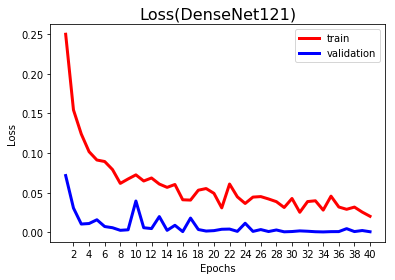

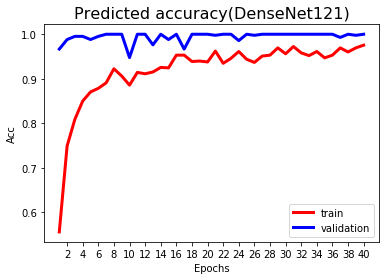

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

print('loss_train: ' + str(loss_train))
print('loss_val: ' + str(loss_val))
print('acc_train: ' + str(acc_train))
print('acc_val: ' + str(acc_val))

# 绘制第一个图，在一幅图上画两条曲线
plt.figure()
plt.title("Loss(DenseNet121)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(2, 41, 2.0))
plt.plot(range(1,epochs + 1), loss_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), loss_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

# 绘制第二个图，在一幅图上画两条曲线
plt.figure()
plt.title("Predicted accuracy(DenseNet121)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.xticks(np.arange(2, 41, 2.0))
plt.plot(range(1,epochs + 1), acc_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), acc_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224])
GroundTruth:     77    79    77    79
Predicted:     77    79    77    79


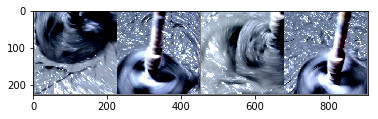

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('75', '77', '79', '81')

dataiter = iter(dataloders['validation'])
images, labels = dataiter.next()
print(images.size())
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[z]] for z in range(4)))

# test
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[z]] for z in range(4)))

In [9]:
conc = {
    '0': '75  ',
    '1': '77  ',
    '2': '79  ',
    '3': '81  '
}

print("\t   Predicted\n")
print("\t   75\t77\t79\t81\n")
for i in range(0, num_classes):
    print("Actual ", end='')
    print(conc[str(i)], end='')
    for j in range(0, num_classes):
        print(str(best_matrix[i][j]) + '\t', end='')
    print('\n')

	   Predicted

	   75	77	79	81

Actual 75  105	0	0	0	

Actual 77  0	105	0	0	

Actual 79  0	0	105	0	

Actual 81  0	0	0	105	

